***BARILLER Halvard*** <br>
***MVA 23/24***

# <center> Computational Statistics 
## <center> Homework 3
### <center> Hasting-Metropolis (and Gibbs) samplers

In [1]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import scipy.stats as stats
import tqdm
import numba
import time
from numba import jit
from scipy.stats import invwishart

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## **Exercise 1**: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

### 1.A – A population model for longitudinal data

We remind the following notations:
- $N$ individuals are observed
- $\forall i \in \{1, \dots, N\}$, we note $(y_{i,j})_{1 \leq j \leq k_i}$ the $k_i$ observations that are made at times $(t_{i,j})_{1 \leq j \leq k_i}$ (the $t_{i,j}$ are ordered)

**Average progression**:
\begin{align*}
d(t) = p_0 + v_0 (t - t_0), \quad \text{with } \begin{cases} p_0 \sim \mathcal{N}(\bar{p_0}, \sigma_{p_0}^2) \\ t_0 \sim \mathcal{N}(\bar{t_0}, \sigma_{t_0}^2) \\ v_0 \sim \mathcal{N}(\bar{v_0}, \sigma_{v_0}^2) \end{cases}
\end{align*}

**Individual progression**:
\begin{align*}
d_i(t) = d(\alpha_i (t-t_0-\tau_i)+t_0) = p_0 + v_0 (\alpha_i (t-t_0-\tau_i)) \\
\end{align*}
For all $j \in \{1, \dots, k_i\}$, we assume:
\begin{align*}
\begin{cases}
y_{i,j} = d_i(t_{i,j}) + \epsilon_{i,j}, \quad \text{with } \epsilon_{i,j} \overset{i.i.d}{\sim} \mathcal{N}(0, \sigma^2) \\
\alpha_i = \exp(\xi_i), \quad \text{with } \xi_i \overset{i.i.d}{\sim} \mathcal{N}(0, \sigma_{\xi}^2) \\
\tau_i \overset{i.i.d}{\sim} \mathcal{N}(0, \sigma_{\tau}^2)
\end{cases}
\end{align*}

Our model is defined with the following:

\begin{aligned}
%& \text {Table 1.1. A Jupyter notebook table using LaTeX }\\
&\begin{array}{cccc}
\hline \text { Fixed } & \text { Parameters } & \text { Latent variables } & \text { Observations } \\
\hline \sigma_{p_0} & \bar{t_0} & (\alpha_i)_{1\leq i \leq N} & (y_{i,j})_{\substack{1\leq i \leq N \\ 1 \leq j \leq k_{i}}} \\
\sigma_{t_0} & \bar{v_0} & (\tau_i)_{1\leq i \leq N} &  \\
\sigma_{v_0} & \sigma_{\xi} & t_0 &  \\
p_0 & \sigma_{\tau} & v_0 & \\
 & \sigma &  &  \\
\hline
\end{array}
\end{aligned}

We note $\theta = (\bar{t_0}, \bar{v_0}, \sigma_{\xi}, \sigma_{\tau}, \sigma)$ the vector of parameters, composed of $\theta_{pop} = (\bar{t_0}, \bar{v_0})$ and $\theta_{ind} = (\sigma_{\xi}, \sigma_{\tau}, \sigma)$. <br>
We note $z = ((z_i)_i, z_{pop})$ the vector of latent variables, where $z_i = (\alpha_i, \tau_i)$ and $z_{pop} = (t_0, v_0)$.

We pose a Bayesian framework with the following prior distributions:
\begin{align*}
\begin{cases}
\bar{t_0} \sim \mathcal{N}(\bar{\bar{t_0}}, s_{t_0}^2) \\
\bar{v_0} \sim \mathcal{N}(\bar{\bar{v_0}}, s_{v_0}^2) \\
\sigma_{\xi}^2 \sim \mathcal{W}^{-1}(v_{\xi}, m_{\xi}) \\
\sigma_{\tau}^2 \sim \mathcal{W}^{-1}(v_{\tau}, m_{\tau}) \\
\sigma^2 \sim \mathcal{W}^{-1}(v, m)
\end{cases}
\end{align*}
where $\mathcal{W}^{-1}(v, m)$ is the Inverse-Gamma distribution with parameters $v$ and $m$, whose density w.r.t. the Lebesgue
measure is given by:
\begin{align*}
f_{\mathcal{W}^{-1}}(\sigma^2) = \frac{1}{\Gamma(\frac{m}{2})} \frac{1}{\sigma^2} \left(\frac{v}{\sigma \sqrt2}\right)^m \exp\left(-\frac{v^2}{2\sigma^2}\right).
\end{align*}

#### **Question 1 :** *Write the complete log-likelihood of the previous model for the observations $\{y_{i,j}\}_{i,j}$ (including the latent variables $z_{pop}$ and $\{z_i\}_i$, and the parameter $\theta$). <br> Show that the proposed model belongs to the curved exponential family, i.e., that the log-likelihood can be written under the explicit form $\log p(y, z, \theta) = −\Phi(\theta) + \langle S(y, z), \Psi(\theta) \rangle$, up to some constant independent of $\theta$.*

For simplification, we note $y = (y_{i,j})_{i,j}$ and $z = ((z_i)_i, z_{pop})$.

We first have that:
\begin{align*}
p(y, z, \theta) &= p(y, z | \theta) p(\theta) = p(y | z, \theta) p(z | \theta) p(\theta).
\end{align*}

We can then write the log-likelihood of the model as:
\begin{align*}
\ell(y, z, \theta) &= \log p(y, z, \theta) \\
&= \underbrace{\log p(y | z, \theta)}_{(1)} + \underbrace{\log p(z | \theta)}_{(2)} + \underbrace{\log p(\theta)}_{(3)} \\
\end{align*}

We now detail each term of the log-likelihood:
- $(1)$:
\begin{align*}
\log p(y | z, \theta) &= \log \prod_{i,j} p(y_{i,j} | z, \theta) \\
&= \sum_{i=1}^N \sum_{j=1}^{k_i} \log p(y_{i,j} | z, \theta) \\
&= \sum_{i=1}^N \sum_{j=1}^{k_i} \log \mathcal{N}(y_{i,j} | d_i(t_{i,j}), \sigma^2) \\
&= \sum_{i=1}^N \sum_{j=1}^{k_i} \log \left\{ \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2}\right) \right\} \\
&= \sum_{i=1}^N \sum_{j=1}^{k_i} \left\{ -\frac{1}{2} \log(2\pi \sigma^2) -\frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2} \right\} \\
&= \sum_{i=1}^N \sum_{j=1}^{k_i} \left\{ -\frac{1}{2} \log \sigma^2 -\frac{(y_{i,j} - d_i(t_{i,j}))^2}{2\sigma^2} \right\} + C_1\\
&= -\frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 + C_1\\
\end{align*}
where $C_1$ is a constant independent of $\theta$.

- $(2)$:
\begin{align*}
\log p(z | \theta) &= \log p(z_{pop} | \theta) + \log p((z_i)_i| \theta) \\
&= \log p(z_{pop} | \theta_{pop}) + \log p((z_i)_i| \theta_{ind}) \\
&= \log p(z_{pop} | \theta_{pop}) + \sum_{i=1}^N \log p(z_i| \theta_{ind}) \\
&= \log p(z_{pop} | \theta_{pop}) + \sum_{i=1}^N \log p(\alpha_i| \theta_{ind}) + \log p(\tau_i| \theta_{ind}) \\
&= \log p(t_0 | \theta_{pop}) + \log p(v_0 | \theta_{pop}) + \sum_{i=1}^N \log p(\alpha_i| \theta_{ind}) + \log p(\tau_i| \theta_{ind}) \\
&= \log \mathcal{N}(t_0 | \bar{t_0}, \sigma_{t_0}^2) + \log \mathcal{N}(v_0 | \bar{v_0}, \sigma_{v_0}^2) + \sum_{i=1}^N \underbrace{\log p(\alpha_i| \theta_{ind})}_{\alpha_i \sim \log\mathcal{N}(0, \sigma_{\xi}^2)} + \log \mathcal{N}(\tau_i | 0, \sigma_{\tau}^2) \\
&= -\frac{(t_0 - \bar{t_0})^2}{2\sigma_{t_0}^2} -\frac{(v_0 - \bar{v_0})^2}{2\sigma_{v_0}^2} + \sum_{i=1}^N \left\{ -\frac{1}{2} \log(2\pi \sigma_{\xi}^2 \alpha_i^2) -\frac{\log(\alpha_i)^2}{2\sigma_{\xi}^2}  -\frac{1}{2} \log(2\pi \sigma_{\tau}^2) -\frac{\tau_i^2}{2\sigma_{\tau}^2} \right\} + C_2 \\
&= -\frac{(t_0 - \bar{t_0})^2}{2\sigma_{t_0}^2} -\frac{(v_0 - \bar{v_0})^2}{2\sigma_{v_0}^2} -\frac{N}{2} \log(\sigma_{\tau}^2 \sigma_{\xi}^2 )+ \sum_{i=1}^N \left\{ -\frac{1}{2} \log(\alpha_i^2) -\frac{\log(\alpha_i)^2}{2\sigma_{\xi}^2}   -\frac{\tau_i^2}{2\sigma_{\tau}^2} \right\} + C_2 \\
&= -\frac{(t_0 - \bar{t_0})^2}{2\sigma_{t_0}^2} -\frac{(v_0 - \bar{v_0})^2}{2\sigma_{v_0}^2} -\frac{N}{2} \log(\sigma_{\tau}^2 \sigma_{\xi}^2 )+ \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2}   -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} + C_2 \\
\end{align*}

- $(3)$:
\begin{align*}
\log p(\theta) &= \log p(\bar{t_0}) + \log p(\bar{v_0}) + \log p(\sigma_{\xi}^2) + \log p(\sigma_{\tau}^2) + \log p(\sigma^2) \\
&= \log \mathcal{N}(\bar{t_0} | \bar{\bar{t_0}}, s_{t_0}^2) + \log \mathcal{N}(\bar{v_0} | \bar{\bar{v_0}}, s_{v_0}^2) + \log \mathcal{W}^{-1}(\sigma_{\xi}^2 | v_{\xi}, m_{\xi}) + \log \mathcal{W}^{-1}(\sigma_{\tau}^2 | v_{\tau}, m_{\tau}) + \log \mathcal{W}^{-1}(\sigma^2 | v, m) \\
\end{align*}
We remark that the last three terms are of the form:
\begin{align*}
\log \mathcal{W}^{-1}(\sigma^2 | v, m) &= \log \left\{ \frac{1}{\Gamma(\frac{m}{2})} \frac{1}{\sigma^2} \left(\frac{v}{\sigma \sqrt2}\right)^m \exp\left(-\frac{v^2}{2\sigma^2}\right) \right\} \\
&= \log \left\{ \frac{1}{\Gamma(\frac{m}{2})} \frac{1}{\sigma^2} \left(\frac{v}{\sigma \sqrt2}\right)^m \right\} + \log \left\{ \exp\left(-\frac{v^2}{2\sigma^2}\right) \right\} \\
&= -\log \Gamma(\frac{m}{2}) -\log \sigma^2 +m \log v - \frac{m}{2} \log 2 \sigma^2 -\frac{v^2}{2\sigma^2} \\
&= -(1+\frac{m}{2} )\log \sigma^2 -\frac{v^2}{2\sigma^2} + C_3 \\
\end{align*}
where $C_3$ is a constant independent of $\theta$.
As a result, we have:
\begin{align*}
\log p(\theta) &= \log \mathcal{N}(\bar{t_0} | \bar{\bar{t_0}}, s_{t_0}^2) + \log \mathcal{N}(\bar{v_0} | \bar{\bar{v_0}}, s_{v_0}^2) + \log \mathcal{W}^{-1}(\sigma_{\xi}^2 | v_{\xi}, m_{\xi}) + \log \mathcal{W}^{-1}(\sigma_{\tau}^2 | v_{\tau}, m_{\tau}) + \log \mathcal{W}^{-1}(\sigma^2 | v, m) \\
&= -\frac{(\bar{t_0} - \bar{\bar{t_0}})^2}{2s_{t_0}^2} -\frac{(\bar{v_0} - \bar{\bar{v_0}})^2}{2s_{v_0}^2} -(1+\frac{m_{\xi}}{2} )\log \sigma_{\xi}^2 -\frac{v_{\xi}^2}{2\sigma_{\xi}^2} -(1+\frac{m_{\tau}}{2} )\log \sigma_{\tau}^2 -\frac{v_{\tau}^2}{2\sigma_{\tau}^2} -(1+\frac{m}{2} )\log \sigma^2 -\frac{v^2}{2\sigma^2} + C_4\\
\end{align*}

We can now write the complete log-likelihood of the model as:
\begin{align*}
\ell(y, z, \theta) = & \log p(y, z, \theta) \\
={} &\underbrace{\log p(y | z, \theta)}_{(1)} + \underbrace{\log p(z | \theta)}_{(2)} + \underbrace{\log p(\theta)}_{(3)} \\
={} &-\frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 + C_1 -\frac{(t_0 - \bar{t_0})^2}{2\sigma_{t_0}^2} -\frac{(v_0 - \bar{v_0})^2}{2\sigma_{v_0}^2} -\frac{N}{2} \log(\sigma_{\tau}^2 \sigma_{\xi}^2 )+ \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2}   -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\}\\
{}&{} + C_2 -\frac{(\bar{t_0} - \bar{\bar{t_0}})^2}{2s_{t_0}^2} -\frac{(\bar{v_0} - \bar{\bar{v_0}})^2}{2s_{v_0}^2} -(1+\frac{m_{\xi}}{2} )\log \sigma_{\xi}^2 -\frac{v_{\xi}^2}{2\sigma_{\xi}^2} -(1+\frac{m_{\tau}}{2} )\log \sigma_{\tau}^2 -\frac{v_{\tau}^2}{2\sigma_{\tau}^2} -(1+\frac{m}{2} )\log \sigma^2 -\frac{v^2}{2\sigma^2} + C_4\\
=&{} -\frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 -\frac{(t_0 - \bar{t_0})^2}{2\sigma_{t_0}^2} -\frac{(v_0 - \bar{v_0})^2}{2\sigma_{v_0}^2} -\frac{N}{2} \log(\sigma_{\tau}^2 \sigma_{\xi}^2 )+ \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2}   -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} \\
{}&{} -\frac{(\bar{t_0} - \bar{\bar{t_0}})^2}{2s_{t_0}^2} -\frac{(\bar{v_0} - \bar{\bar{v_0}})^2}{2s_{v_0}^2} -(1+\frac{m_{\xi}}{2} )\log \sigma_{\xi}^2 -\frac{v_{\xi}^2}{2\sigma_{\xi}^2} -(1+\frac{m_{\tau}}{2} )\log \sigma_{\tau}^2 -\frac{v_{\tau}^2}{2\sigma_{\tau}^2} -(1+\frac{m}{2} )\log \sigma^2 -\frac{v^2}{2\sigma^2} + C_5\\
\end{align*}
where $C_5$ is a constant independent of $\theta$.


We now show that the proposed model belongs to the curved exponential family, i.e., that the log-likelihood can be written under the explicit form $\log p(y, z, \theta) = −\Phi(\theta) + \langle S(y, z), \Psi(\theta) \rangle$, up to some constant independent of $\theta$. <br>
We first gather the terms of the log-likelihood that depend solely on $\theta$:
\begin{align*}
\Phi(\theta) =&{} \frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i +\frac{\bar{t_0}^2}{2\sigma_{t_0}^2} +\frac{\bar{v_0}^2}{2\sigma_{v_0}^2}+\frac{N}{2} \log(\sigma_{\tau}^2 \sigma_{\xi}^2 ) +\frac{(\bar{t_0} - \bar{\bar{t_0}})^2}{2s_{t_0}^2} +\frac{(\bar{v_0} - \bar{\bar{v_0}})^2}{2s_{v_0}^2} +(1+\frac{m_{\xi}}{2} )\log \sigma_{\xi}^2 +\frac{v_{\xi}^2}{2\sigma_{\xi}^2} +(1+\frac{m_{\tau}}{2} )\log \sigma_{\tau}^2 \\
& {} +\frac{v_{\tau}^2}{2\sigma_{\tau}^2} +(1+\frac{m}{2} )\log \sigma^2 +\frac{v^2}{2\sigma^2} \\
=&{} \frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i +\frac{\bar{t_0}^2}{2\sigma_{t_0}^2} +\frac{\bar{v_0}^2}{2\sigma_{v_0}^2} +\frac{(\bar{t_0} - \bar{\bar{t_0}})^2}{2s_{t_0}^2} +\frac{(\bar{v_0} - \bar{\bar{v_0}})^2}{2s_{v_0}^2} +(1+\frac{m_{\xi}}{2}+\frac{N}{2})\log \sigma_{\xi}^2 +\frac{v_{\xi}^2}{2\sigma_{\xi}^2} +(1+\frac{m_{\tau}}{2} + \frac{N}{2})\log \sigma_{\tau}^2 \\
& {} +\frac{v_{\tau}^2}{2\sigma_{\tau}^2} +(1+\frac{m}{2} )\log \sigma^2 +\frac{v^2}{2\sigma^2} \\
=&{} \frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i +\frac{\bar{t_0}^2}{2\sigma_{t_0}^2} +\frac{\bar{v_0}^2}{2\sigma_{v_0}^2} +\frac{\bar{t_0}^2}{2s_{t_0}^2} -\frac{\bar{t_0}\bar{\bar{t_0}}}{2s_{t_0}^2} +\frac{\bar{v_0}^2}{2s_{v_0}^2} -\frac{\bar{v_0}\bar{\bar{v_0}}}{2s_{v_0}^2}+(1+\frac{m_{\xi}}{2}+\frac{N}{2})\log \sigma_{\xi}^2 +\frac{v_{\xi}^2}{2\sigma_{\xi}^2} +(1+\frac{m_{\tau}}{2} + \frac{N}{2})\log \sigma_{\tau}^2 \\
& {} +\frac{v_{\tau}^2}{2\sigma_{\tau}^2} +(1+\frac{m}{2} )\log \sigma^2 +\frac{v^2}{2\sigma^2} + c
\end{align*}
where $c$ is a constant independant of $\theta$.

We consider the remaining terms of the log-likelihood:
\begin{align*}
\ell(y, z, \theta) + \Phi(\theta) = & -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 -\frac{t_0^2 - 2t_0\bar{t_0}}{2\sigma_{t_0}^2} -\frac{v_0^2 - 2v_0\bar{v_0}}{2\sigma_{v_0}^2} + \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2}   -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} + C_5\\
\end{align*}

Identifying the sufficient statistics, we can then pose the following:

$$S(y, z) = \begin{pmatrix}
\frac{1}{\sum_{i=1}^N k_i}\sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 \\
\frac{1}{N}\sum_{i=1}^N \log (\alpha_i)^2 \\
\frac{1}{N}\sum_{i=1}^N \tau_i^2 \\
t_0 \\
v_0
\end{pmatrix}, \quad

\Psi(\theta) = \begin{pmatrix}
-(\sum_{i=1}^N k_i)/2\sigma^2 \\
-N/2\sigma_{\xi}^2 \\
-N/2\sigma_{\tau}^2 \\
\frac{\bar{t_0}}{\sigma_{t_0}^2} \\
\frac{\bar{v_0}}{\sigma_{v_0}^2}
\end{pmatrix}
$$

Using these expressions, we can finally write the log-likelihood as:
\begin{align*}
\ell(y, z, \theta) = & -\Phi(\theta) + \langle S(y, z), \Psi(\theta) \rangle + C_6 \\
\end{align*}
where $C_6$ is a constant independent of $\theta$.


#### **Question 2 :** *Generate synthetic data from the model by taking some reasonable values for the parameters.*

We pose the following parameters:
- $\sigma_{t_0} = \sigma_{v_0} =0.1$
- $s_{t_0} =s_{v_0} =0.1$
- $\bar{\bar{t_0}} =\bar{\bar{v_0}}=1$
- $m= m_{\xi} = m_{\tau} \in [5,10]$
- $v=v_{\xi} = v_{\tau} \in[1,5]$
- $N = 100$
- $k_i = 20$

In [2]:
# Fixed parameters
np.random.seed(42)

p_0_b = 10
sigma_p_0 = 0.2
p_0 = np.random.normal(p_0_b, sigma_p_0**2)
print(f"p_0 = {p_0}")

sigma_t_0 = sigma_v_0 = 0.1
s_t_0 = s_v_0 = 0.1
t_0_bb = v_0_bb = 1
m = 6
v = 2
N = 100
k = 20


p_0 = 10.019868566120449


In [3]:
# Target parameters
np.random.seed(42)

target_sigma_xi = np.sqrt(invwishart.rvs(df=m, scale=v))
target_sigma_tau = np.sqrt(invwishart.rvs(df=m, scale=v))
target_sigma = np.sqrt(invwishart.rvs(df=m, scale=v))
target_t_0_b = np.random.normal(t_0_bb, s_t_0)
target_v_0_b = np.random.normal(v_0_bb, s_v_0)

print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)

target_theta = [target_sigma_xi, target_sigma_tau, target_sigma, target_t_0_b, target_v_0_b]

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


**So as not to overcomplicate the functions, the fixed parameters are defined as global variables further on.**

In [4]:
@jit(nopython=True)
def average_progression(t, t_0, v_0):
    """
    Compute the average progression of a population
    """
    return p_0 + v_0 * (t - t_0)

In [5]:
@jit(nopython=True)
def individual_progression(t, xi, tau, t_0, v_0,):
    """
    Simulate the progression of an individual
    """
    alpha = np.exp(xi)
    return p_0 + v_0 * alpha * (t - t_0 - tau)

In [6]:
@jit(nopython=True)
def generate_individuals(N, k, parameters):
    """
    Generate the data for N individuals
    ----------
    Parameters:
    N : Number of individuals
    k : Number of time points
    parameters : List of parameters
    """

    np.random.seed(42)
    
    sigma_xi, sigma_tau, sigma, t_0_b, v_0_b = parameters

    # Generate the initial values
    t_0 = np.random.normal(t_0_b, sigma_t_0)
    v_0 = np.random.normal(v_0_b, sigma_v_0)

    # Generate the times
    times = np.linspace(0, k, k)

    # Generate the average progression
    avg = np.zeros(k)
    for j in range(k):
        avg[j] = average_progression(times[j], t_0, v_0)

    # Generate the individual measurements
    y = np.zeros((N, k))
    xi = np.random.normal(0, sigma_xi, N)
    tau = np.random.normal(0, sigma_tau, N)
    
    for i in range(N):
        for j in range(k):
            eps = np.random.normal(0, sigma)
            y[i, j] = individual_progression(times[j], xi[i], tau[i], t_0, v_0) + eps
    
    return y, avg, times, tau, xi, t_0, v_0

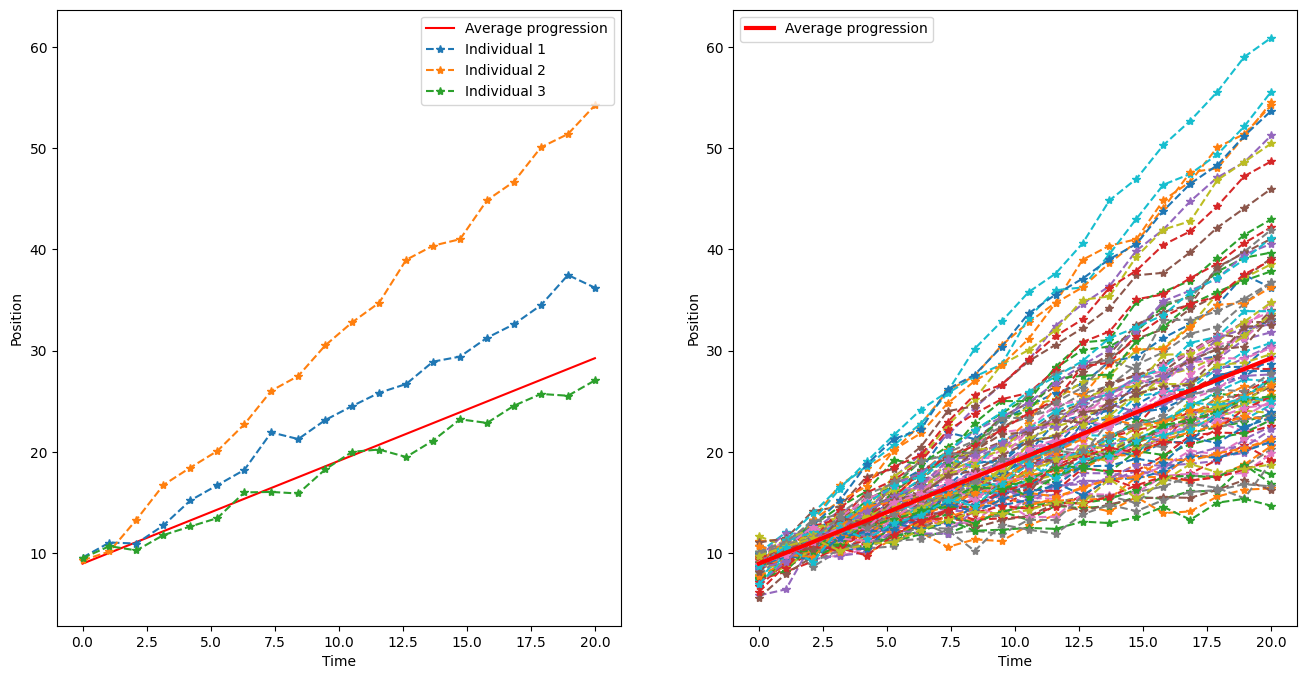

In [7]:
# target_theta = numba.typed.List(target_theta)

y, avg, times, tau_true, xi_true, t_0_true, v_0_true = generate_individuals(N, k, target_theta)


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(times, avg, color='red', label="Average progression")
ax[0].plot(times, y[0], '*--', label="Individual 1")
ax[0].plot(times, y[1], '*--', label="Individual 2")
ax[0].plot(times, y[2], '*--', label="Individual 3")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Position")
ax[0].legend()


for i in range(N):
    ax[1].plot(times, y[i], '*--')
ax[1].plot(times, avg, color = 'red', label="Average progression", linewidth=3)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Position")
ax[1].legend()

# ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_ylim(ax[1].get_ylim())


plt.show()


In [10]:
from ipywidgets import interact, FloatSlider, IntSlider

def show_data(N = N, 
              k = k, 
              t_0_b = target_t_0_b, 
              v_0_b = target_v_0_b, 
              sigma_xi = target_sigma_xi,
              sigma_tau = target_sigma_tau,
              sigma = target_sigma
              ):

    parameters = [sigma_xi, sigma_tau, sigma, t_0_b, v_0_b]
    y, avg, times, tau, xi, t_0, v_0 = generate_individuals(N=N, k=k,
                                                    parameters=parameters)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    ax[0].plot(times, avg, color='red', label="Average progression")
    ax[0].plot(times, y[0], '*--', label="Individual 1")
    ax[0].plot(times, y[1], '*--', label="Individual 2")
    ax[0].plot(times, y[2], '*--', label="Individual 3")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Position")
    ax[0].legend()


    for i in range(N):
        ax[1].plot(times, y[i], '*--')
    ax[1].plot(times, avg, color = 'red', label="Average progression", linewidth=3)
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Position")
    ax[1].legend()
    ax[0].set_ylim(ax[1].get_ylim())

interact(show_data,
            N=IntSlider(min=1, max=100, step=1, value=N),
            k=IntSlider(min=1, max=100, step=1, value=k),
            t_0_b=FloatSlider(min=0, max=2, step=0.1, value=target_t_0_b),
            v_0_b=FloatSlider(min=0, max=2, step=0.1, value=target_v_0_b),
            sigma_xi=FloatSlider(min=0, max=2, step=0.1, value=target_sigma_xi),
            sigma_tau=FloatSlider(min=0, max=2, step=0.1, value=target_sigma_tau),
            sigma=FloatSlider(min=0, max=2, step=0.1, value=target_sigma),
            p_0=FloatSlider(min=p_0_b/2, max=p_0_b*3/2, step=0.1, value=p_0))

interactive(children=(IntSlider(value=100, description='N', min=1), IntSlider(value=20, description='k', min=1…

<function __main__.show_data(N=100, k=20, t_0_b=0.976586304305082, v_0_b=1.0279041292200137, sigma_xi=0.5297892487600045, sigma_tau=0.6392426821613534, sigma=0.6590538116821373)>

### 1.B – HM-SAEM – Hasting-Metropolis sampler

#### **Question 3 :** *Propose a Metropolis-Hasting sampler to sample from the a posteriori distribution $p(z | y, \theta)$ of the latent variable $z = (z_{pop}, z_i)_{i \in \{1,N\}} = (t_0, v_0, \xi_i, \tau_i)_{i \in \{1,N\}} \in \mathbb{R}^{2N+2}$.*

A natural choice for the proposal distribution is to consider a multivariate Gaussian distribution $\mathcal{N}(z, \sigma_{prop}^2 I)$. Thus, the acceptance ratio simply writes $1 \wedge \frac{\pi(z^*)}{\pi(z^{(k)})}$ . This algorithm is called Symmetric Random Walk Hasting-Metropolis algorithm. <br>

We write the posterior distribution:
\begin{align*}
p(z|y, \theta) = \frac{p(z,y|\theta)}{p(y|\theta)} = \frac{p(y|z,\theta)p(z|\theta)}{p(y|\theta)} 
\end{align*}
The loglikelihood gives:
\begin{align*}
\log p(z|y, \theta) ={}& \log p(y|z,\theta) + \log p(z|\theta) + C_{(y,\theta)} \\
={}& -\frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 + C_1 -\frac{(t_0 - \bar{t_0})^2}{2\sigma_{t_0}^2} -\frac{(v_0 - \bar{v_0})^2}{2\sigma_{v_0}^2} -\frac{N}{2} \log(\sigma_{\tau}^2 \sigma_{\xi}^2 ) \\
{}& + \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2} -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} + C_2 + C_{(y,\theta)}\\
={}& -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 -\frac{t_0^2 - 2t_0\bar{t_0}}{2\sigma_{t_0}^2} -\frac{v_0^2 - 2v_0\bar{v_0}}{2\sigma_{v_0}^2} + \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2} -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} + C_{(y,\theta)} + C
\end{align*}

In [9]:
z_true = np.concatenate((xi_true, tau_true, np.array([t_0_true, v_0_true])))

In [10]:
@jit(nopython=True)
def target_distribution(z, theta):
    """
    Computes the log-likelihood according to the target distribution p(z| y, theta)
    ------------------
    Parameters:
    z: latent variables
    theta: parameters of the target distribution
    """
    
    t = times
    N = y.shape[0]
    k = y.shape[1]
    xi = z[:N]
    tau = z[N:2*N]
    t_0 = z[-2]
    v_0 = z[-1]
    sigma_xi, sigma_tau, sigma, t_0_b, v_0_b = theta

    alpha = np.exp(xi)
    
    term_1 = 0
    for i in range(N):
        for j in range(k):
            term_1 += (y[i,j] - individual_progression(t[j], xi[i], tau[i], t_0, v_0))**2
    term_1 *= - 1 / (2 * sigma**2)
    
    term_2 = - (t_0**2 - 2 * t_0 * t_0_b) / (2 * sigma_t_0**2)
    term_3 = - (v_0**2 - 2 * v_0 * v_0_b) / (2 * sigma_v_0**2)
    term_4 = np.sum(- xi - 1 / (2 * sigma_xi**2) * np.power(xi, 2) - 1 / (2 * sigma_tau**2) * np.power(tau, 2))

    return term_1 + term_2 + term_3 + term_4

In [11]:
@jit(nopython=True)
def symmetric_rw_hm_sampler(sigma_prop, z_0, theta, 
                            target_distribution, 
                            max_iter = 1000
                            ):
    """
    Metropolis-Hasting sampler with a multivariate Gaussian for proposal distribution.
    -----------------
    Parameters:
    sigma_prop: standard deviation of the proposal distribution
    z_0: initial value of the latent variables
    theta: parameters of the target distribution
    target_distribution: function that computes the log-likelihood of the target distribution
    max_iter: maximum number of iterations
    """
    
    acceptance_rate = 0
    z = z_0
    
    for _ in range(max_iter):

        loglik_z = target_distribution(z, theta)

        ### To use numba, we take advantage of the independance and identical distribution of the Gaussians to sample them one by one
        z_temp = np.zeros(z.shape[0])
        for i in range(z.shape[0]):
            z_temp[i] = z[i] + sigma_prop * np.random.randn()
       
        loglik_z_temp = target_distribution(z_temp, theta)
        
        acceptance_criterion = min(0, loglik_z_temp - loglik_z)
        acceptance_criterion = np.exp(acceptance_criterion)

        assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion'
        
        if np.random.rand() < acceptance_criterion:
            z = z_temp
            acceptance_rate += 1
        
    acceptance_rate /= max_iter
    
    return z, acceptance_rate


In [12]:
z, acceptance_ratio = symmetric_rw_hm_sampler(2e-3, z_true, target_theta, target_distribution, max_iter = 1000)
print(acceptance_ratio)

0.262


Latent parameters:
t_0:  1.0262577196062053
v_0:  1.0140776991028952


Approximated latent parameters:
t_0:  1.0159704021713956
v_0:  1.012388404428016


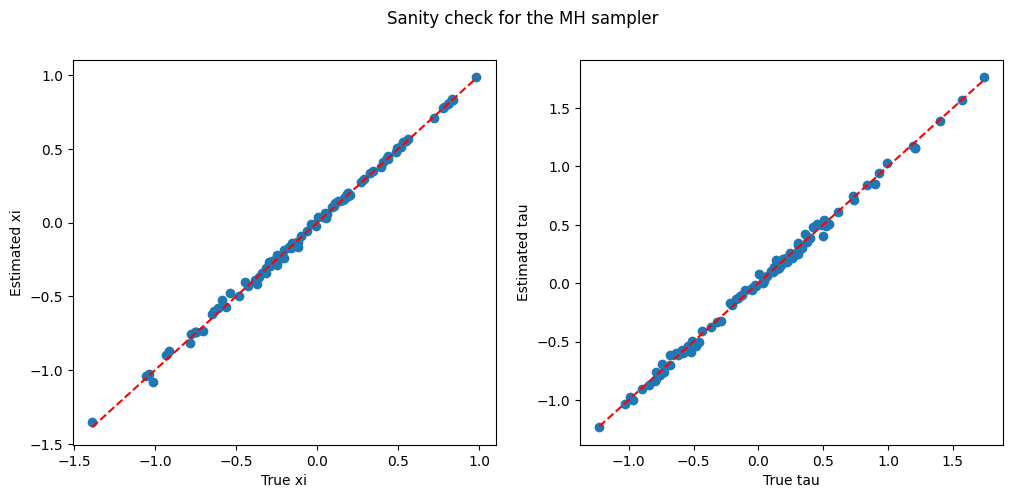

In [13]:
# Sanity check

print("Latent parameters:")
print("t_0: ", t_0_true)
print("v_0: ", v_0_true)
print("\n")
print("Approximated latent parameters:")
print("t_0: ", z[-2])
print("v_0: ", z[-1])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(xi_true, z[:N], label="xi")
ax[0].plot([np.min(xi_true), np.max(xi_true)], [np.min(xi_true), np.max(xi_true)], 'k--', color='red')
ax[1].scatter(tau_true, z[N:2*N], label="tau")
ax[1].plot([np.min(tau_true), np.max(tau_true)], [np.min(tau_true), np.max(tau_true)], 'k--', color='red')
ax[0].set_xlabel("True xi")
ax[0].set_ylabel("Estimated xi")
ax[1].set_xlabel("True tau")
ax[1].set_ylabel("Estimated tau")

fig.suptitle("Sanity check for the MH sampler")
plt.show()

#### **Question 4 :** *Compute the optimal parameters at step $k$ and implement the HM-SAEM in order to find the MAP of your model. In particular, we assume that the MAP exists.*

We recall the expression of the log-likelihood as a curved exponential model:
\begin{align*}
\ell(y, z, \theta) = & -\Phi(\theta) + \langle S(y, z), \Psi(\theta) \rangle + C_6 \\
\end{align*}
where $C_6$ is a constant independent of $\theta$. In our model, we considered the parameters $m_{\xi}$, $m_{\tau}$ and $m$ as well as the parameters $v_{\xi}$, $v_{\tau}$ and $v$ to be equal. We also considered the parameters $k_i$ to be all equal.
Thus, we have:
\begin{align*}
\Phi(\theta) =&{} \frac{1}{2} \log \sigma^2 \sum_{i=1}^N k_i +\frac{\bar{t_0}^2}{2\sigma_{t_0}^2} +\frac{\bar{v_0}^2}{2\sigma_{v_0}^2} +\frac{\bar{t_0}^2}{2s_{t_0}^2} -\frac{\bar{t_0}\bar{\bar{t_0}}}{2s_{t_0}^2} +\frac{\bar{v_0}^2}{2s_{v_0}^2} -\frac{\bar{v_0}\bar{\bar{v_0}}}{2s_{v_0}^2}+(1+\frac{m_{\xi}}{2}+\frac{N}{2})\log \sigma_{\xi}^2 +\frac{v_{\xi}^2}{2\sigma_{\xi}^2} +(1+\frac{m_{\tau}}{2} + \frac{N}{2})\log \sigma_{\tau}^2 \\
& {} +\frac{v_{\tau}^2}{2\sigma_{\tau}^2} +(1+\frac{m}{2} )\log \sigma^2 +\frac{v^2}{2\sigma^2} + c \\
=&{} \frac{\bar{t_0}^2}{2\sigma_{t_0}^2} +\frac{\bar{v_0}^2}{2\sigma_{v_0}^2} +\frac{\bar{t_0}^2}{2s_{t_0}^2} -\frac{\bar{t_0}\bar{\bar{t_0}}}{2s_{t_0}^2} +\frac{\bar{v_0}^2}{2s_{v_0}^2} -\frac{\bar{v_0}\bar{\bar{v_0}}}{2s_{v_0}^2}+(1+\frac{m}{2}+\frac{N}{2})(\log \sigma_{\xi}^2 + \log \sigma_{\tau}^2) + v^2 \left(\frac{1}{2\sigma_{\xi}^2}  +\frac{1}{2\sigma_{\tau}^2} +\frac{1}{2\sigma^2}\right)\\
& {} +(1+\frac{m}{2} + \frac{Nk}{2})\log \sigma^2  + c \\
\end{align*}
and
$$S(y, z) = \begin{pmatrix}
\frac{1}{Nk}\sum_{i=1}^N \sum_{j=1}^{k} (y_{i,j} - d_i(t_{i,j}))^2 \\
\frac{1}{N}\sum_{i=1}^N \xi_i^2 \\
\frac{1}{N}\sum_{i=1}^N \tau_i^2 \\
t_0 \\
v_0
\end{pmatrix}, \quad
\Psi(\theta) = \begin{pmatrix}
-(Nk)/2\sigma^2 \\
-N/2\sigma_{\xi}^2 \\
-N/2\sigma_{\tau}^2 \\
\frac{\bar{t_0}}{\sigma_{t_0}^2} \\
\frac{\bar{v_0}}{\sigma_{v_0}^2}
\end{pmatrix}
$$

At step $k$, we have:
\begin{align*}
\theta^{(k)} = \arg \max_{\theta} \ell(y, z^{(k)}, \theta) = \arg \max_{\theta} \left\{ -\Phi(\theta) + \langle S(y, z^{(k)}), \Psi(\theta) \rangle \right\}
\end{align*}

Considering the fact that the log-likelihood is concave in an exponential family [[WAS04](https://www.stat.cmu.edu/~larry/=stat705/Lecture12a.pdf)], we use the first-order condition to find the optimal parameters:
\begin{align*}
\nabla_{\theta} \ell(y, z^{(k)}, \theta^*) = 0 \iff \nabla_{\theta} \left\{ -\Phi(\theta) + \langle S(y, z^{(k)}), \Psi(\theta) \rangle \right\} = 0
\end{align*}


We first compute the gradient of $\Phi(\theta)$:
\begin{align*}
\partial_{\sigma_{\xi}^2} \Phi(\theta)&= (1 + \frac{m}{2} + \frac{N}{2}) \frac{1}{\sigma_{\xi}^2} -  \frac{v^2}{2\sigma_{\xi}^4}\\
\partial_{\sigma_{\tau}^2} \Phi(\theta)&= (1 + \frac{m}{2} + \frac{N}{2}) \frac{1}{\sigma_{\tau}^2} -  \frac{v^2}{2\sigma_{\tau}^4}\\
\partial_{\sigma^2} \Phi(\theta)&= (1 + \frac{m}{2} + \frac{Nk}{2}) \frac{1}{\sigma^2} -  \frac{v^2}{2\sigma^4}\\
\partial_{\bar{t_0}} \Phi(\theta)&= \bar{t_0} \left(\frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}\right) - \frac{\bar{\bar{t_0}}}{s_{t_0}^2}\\
\partial_{\bar{v_0}} \Phi(\theta)&= \bar{v_0} \left(\frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}\right) - \frac{\bar{\bar{v_0}}}{s_{v_0}^2}\\
\end{align*}

We then compute the gradient of $\langle S(y, z^{(k)}), \Psi(\theta) \rangle$:
\begin{align*}
\partial_{\sigma_{\xi}^2} \langle S(y, z^{(k)}), \Psi(\theta) \rangle&= S^{(2)}(y, z^{(k)}) \frac{N}{2\sigma_{\xi}^4} \\
\partial_{\sigma_{\tau}^2} \langle S(y, z^{(k)}), \Psi(\theta) \rangle&= S^{(3)}(y, z^{(k)}) \frac{N}{2\sigma_{\tau}^4} \\
\partial_{\sigma^2} \langle S(y, z^{(k)}), \Psi(\theta) \rangle&= S^{(1)}(y, z^{(k)}) \frac{Nk}{2\sigma^4} \\
\partial_{\bar{t_0}} \langle S(y, z^{(k)}), \Psi(\theta) \rangle&= S^{(4)}(y, z^{(k)}) \frac{1}{\sigma_{t_0}^2} \\
\partial_{\bar{v_0}} \langle S(y, z^{(k)}), \Psi(\theta) \rangle&= S^{(5)}(y, z^{(k)}) \frac{1}{\sigma_{v_0}^2} \\
\end{align*}

Gathering the terms, we have:
\begin{align*}
\nabla_{\theta} \ell(y, z^{(k)}, \theta^*) = 0 & \iff \nabla_{\theta} \left\{ -\Phi(\theta^*) + \langle S(y, z^{(k)}), \Psi(\theta^*) \rangle \right\} = 0 \\
& \iff \nabla_{\theta} \Phi(\theta^*) = \nabla_{\theta^*} \langle S(y, z^{(k)}), \Psi(\theta^*) \rangle \\
\end{align*}
Therefore, we can finally solve:
$$\begin{cases}
(1 + \frac{m}{2} + \frac{N}{2}) \frac{1}{\sigma_{\xi}^2} -  \frac{v^2}{2\sigma_{\xi}^4} &= S^{(2)}(y, z^{(k)}) \frac{N}{2\sigma_{\xi}^4} \\
(1 + \frac{m}{2} + \frac{N}{2}) \frac{1}{\sigma_{\tau}^2} -  \frac{v^2}{2\sigma_{\tau}^4} &= S^{(3)}(y, z^{(k)}) \frac{N}{2\sigma_{\tau}^4} \\
(1 + \frac{m}{2} + \frac{Nk}{2}) \frac{1}{\sigma^2} -  \frac{v^2}{2\sigma^4} &= S^{(1)}(y, z^{(k)}) \frac{Nk}{2\sigma^4} \\
\bar{t_0} \left(\frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}\right) - \frac{\bar{\bar{t_0}}}{s_{t_0}^2} &= S^{(4)}(y, z^{(k)}) \frac{1}{\sigma_{t_0}^2} \\
\bar{v_0} \left(\frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}\right) - \frac{\bar{\bar{v_0}}}{s_{v_0}^2} &= S^{(5)}(y, z^{(k)}) \frac{1}{\sigma_{v_0}^2} \\
\end{cases} \iff 
\begin{cases}
\sigma_{\xi}^2 &= \left(S^{(2)}(y, z^{(k)})N+v^2\right) / (2 + m + N) \\
\sigma_{\tau}^2 &= \left(S^{(3)}(y, z^{(k)})N+v^2\right) / (2 + m + N) \\
\sigma^2 &= \left(S^{(1)}(y, z^{(k)})Nk+v^2\right) / (2 + m + Nk) \\
\bar{t_0} &= \left(\frac{S^{(4)}(y, z^{(k)})}{\sigma_{t_0}^2} + \frac{\bar{\bar{t_0}}}{s_{t_0}^2}\right) / \left(\frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}\right) \\
\bar{v_0} &= \left(\frac{S^{(5)}(y, z^{(k)})}{\sigma_{v_0}^2} + \frac{\bar{\bar{v_0}}}{s_{v_0}^2}\right) / \left(\frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}\right) \\
\end{cases}
$$

In [14]:
@jit(nopython=True)
def S_curved(z):
    """
    Computes the S function based on the latent parameters z and the observations y
    """
    xi = z[:N]
    tau = z[N:2*N]
    t_0 = z[-2]
    v_0 = z[-1]
    S = np.zeros(5)
    for i in range(N):
        for j in range(k):
            S[0] += (y[i,j] - individual_progression(times[j], xi[i], tau[i], t_0, v_0))**2
    S[0] *= 1 / (N * k)
    S[1] = np.sum(np.power(xi, 2)) / N
    S[2] = np.sum(np.power(tau, 2)) / N
    S[3] = t_0
    S[4] = v_0
    return S


In [15]:
@jit(nopython=True)
def Psi_curved(theta):
    """
    Computes the Psi function based on the parameters theta and the observations y
    """
    sigma_xi, sigma_tau, sigma, t_0_b, v_0_b = theta
    Psi = np.zeros(5)
    Psi[0] = - N * k / (2 * sigma**2)
    Psi[1] = - N / (2 * sigma_xi**2)
    Psi[2] = - N / (2 * sigma_tau**2)
    Psi[3] = t_0_b / (sigma_t_0**2)
    Psi[4] = v_0_b / (sigma_v_0**2)
    return Psi

In [16]:
@jit(nopython=True)
def maximization_step(z, theta, S):
    """
    Computes the maximization step of the EM algorithm
    -------------
    Parameters:
    z: latent variables
    theta: parameters of the target distribution
    S: stochastic approximation of the S function
    """
    theta_new = np.zeros(5)

    theta_new[0] = np.sqrt((S[1] * N + v**2) / (N + m + 2))
    theta_new[1] = np.sqrt((S[2] * N + v**2) / (N + m + 2))
    theta_new[2] = np.sqrt((S[0] * N * k + v**2) / (N * k + m + 2))
    theta_new[3] = (S[3] / sigma_t_0**2 + t_0_bb / s_t_0**2) / (1 / sigma_t_0**2 + 1 / s_t_0**2)
    theta_new[4] = (S[4] / sigma_v_0**2 + v_0_bb / s_v_0**2) / (1 / sigma_v_0**2 + 1 / s_v_0**2)

    return theta_new
    

In [17]:
@jit(nopython=True)
def HM_SAEM(z_0:numpy.ndarray, theta_0:list, max_iter:int, sigma_prop, target_distribution, S_curved):
    """
    Hybrid Monte Carlo - Stochastic Approximation EM algorithm
    --------------
    Parameters:
    z:  latent variables
    theta: parameters of the target distribution
    max_iter: maximum number of iterations
    sigma_prop: standard deviation of the proposal distribution
    target_distribution: function that computes the log-likelihood of the target distribution
    S_curved: function that computes the S function
    """
    theta_iterates = [np.array(theta_0)]
    z_iterates = [z_0]
    acceptance_hist = np.empty(0)
    burn_in = int(max_iter / 2)
    steps = np.ones(max_iter)
    for i in range(burn_in, max_iter):
        steps[i] = (i + 1 - burn_in)**(-0.6)
    theta = np.array(theta_0)
    z = z_0
    
    for i in range(max_iter):
        if (i+1) % 1000 == 0:
            # print(f"{i+1} iterations done")
            assert np.mean(acceptance_hist) >= 0.2, "Acceptance ratio below 20%, need to reduce sigma_prop"
            assert np.mean(acceptance_hist) <= 0.4, "Acceptance ratio above 40%, need to increase sigma_prop"
        S = S_curved(z)
        ## Simulation
        z_new, acceptance_ratio = symmetric_rw_hm_sampler(sigma_prop, z, theta, target_distribution, max_iter = 1000)
        acceptance_hist = np.append(acceptance_hist, acceptance_ratio)
        ## Stochastic approximation
        S_new = S + steps[i] * (S_curved(z_new) - S)
        # ## Maximization step
        theta_new = maximization_step(z, theta, S_new)
        ## Update
        z = z_new
        theta = theta_new
        z_iterates.append(z)
        theta_iterates.append(theta)

    return z_iterates, theta_iterates, acceptance_hist
    

In [18]:
# Timing of the algorithm

start = time.time()
z_iterates, theta_iterates, acceptance_hist = HM_SAEM(z_true, target_theta, 1000, 2e-3, target_distribution, S_curved)
end = time.time()

time_HM_SAEM = end - start

print(f"Execution time of the HM-SAEM algorithm: {time_HM_SAEM} seconds")

Execution time of the HM-SAEM algorithm: 8.827580213546753 seconds


##### **Sanity checks**

Latent parameters:
t_0:  1.0262577196062053
v_0:  1.0140776991028952


Approximated latent parameters:
t_0:  1.0098100027801682
v_0:  1.1228828723546844


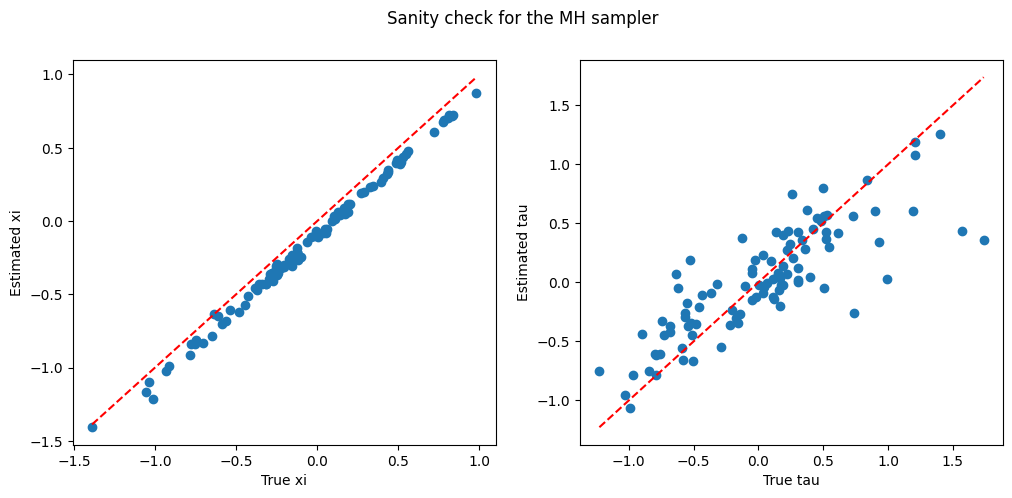

In [19]:
### Convergence of the latent parameters given the target parameters ###

# Latent parameters are initialized at 0

z_iterates, theta_estimated_HMwG_SAEM, acceptance_hist = HM_SAEM(np.zeros(2*N+2), target_theta, 1000, 2e-3, target_distribution, S_curved)
z_estimated = np.mean(z_iterates, axis=0)
print("Latent parameters:")
print("t_0: ", t_0_true)
print("v_0: ", v_0_true)
print("\n")
print("Approximated latent parameters:")
print("t_0: ", z_estimated[-2])
print("v_0: ", z_estimated[-1])


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(xi_true, z_estimated[:N], label="xi")
ax[0].plot([np.min(xi_true), np.max(xi_true)], [np.min(xi_true), np.max(xi_true)], 'k--', color='red')
ax[1].scatter(tau_true, z_estimated[N:2*N], label="tau")
ax[1].plot([np.min(tau_true), np.max(tau_true)], [np.min(tau_true), np.max(tau_true)], 'k--', color='red')
ax[0].set_xlabel("True xi")
ax[0].set_ylabel("Estimated xi")
ax[1].set_xlabel("True tau")
ax[1].set_ylabel("Estimated tau")

fig.suptitle("Sanity check for the MH sampler")
plt.show()

In [20]:
### Convergence of the target parameters given the latent parameters ###

# Target parameters are initialized at 0.1

np.random.seed(42)

z_iterates_HM_SAEM, theta_iterates_HM_SAEM, acceptance_hist_HM_SAEM = HM_SAEM(z_true, [0.1, 0.1, 0.1, 0.1, 0.1], 1000, 2e-3, target_distribution, S_curved)
theta_estimated_HM_SAEM = theta_iterates_HM_SAEM[-1]
print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)
print("\n")
print("Approximated target parameters:")
print("sigma_xi: ", theta_estimated_HM_SAEM[0])
print("sigma_tau: ", theta_estimated_HM_SAEM[1])
print("sigma: ", theta_estimated_HM_SAEM[2])
print("t_0_b: ", theta_estimated_HM_SAEM[3])
print("v_0_b: ", theta_estimated_HM_SAEM[4])
print("\n")
print("Norm of the difference between the true and the estimated parameters: ", np.linalg.norm(theta_estimated_HM_SAEM - target_theta))

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


Approximated target parameters:
sigma_xi:  0.5482287627391629
sigma_tau:  0.6202322442005487
sigma:  0.6601980998254037
t_0_b:  1.0107604850690928
v_0_b:  1.111030795312001


Norm of the difference between the true and the estimated parameters:  0.09370506426583383


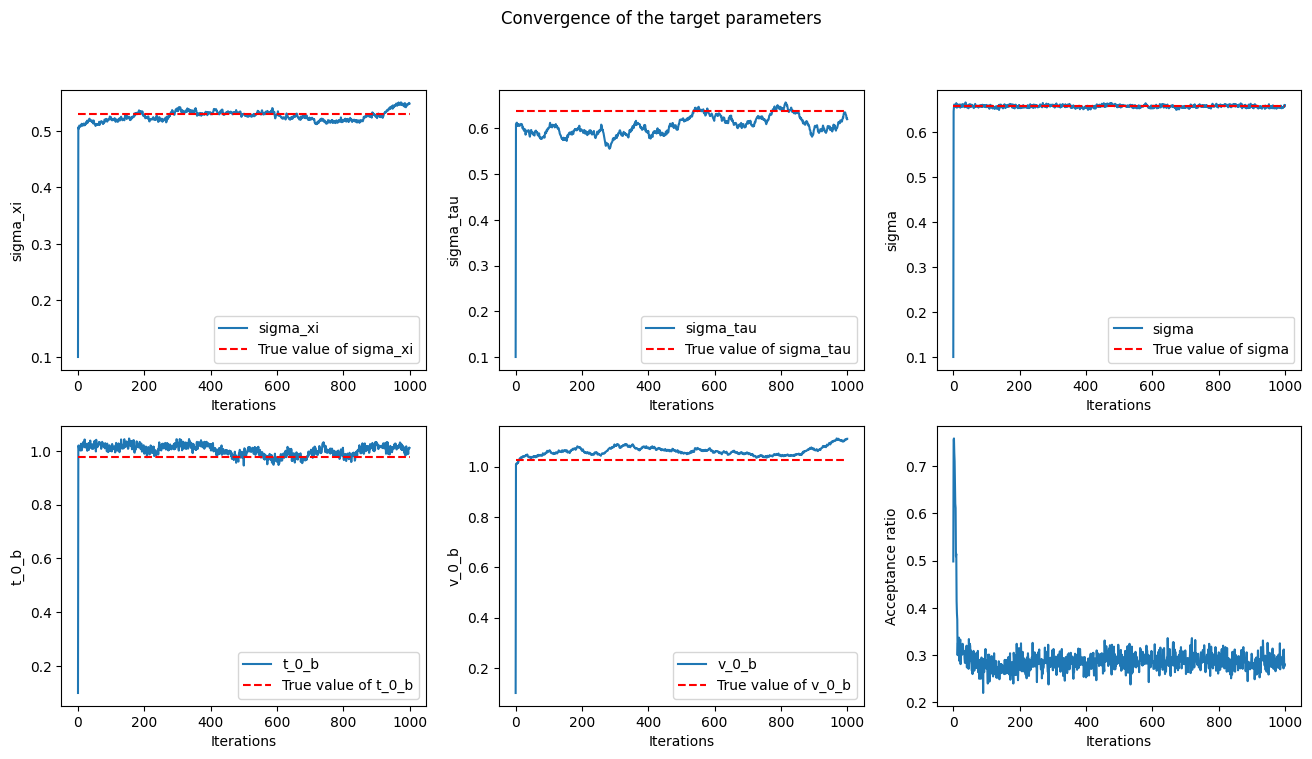

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

ax[0,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[0] for theta in theta_iterates_HM_SAEM], label="sigma_xi")
ax[0,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_sigma_xi for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of sigma_xi")
ax[0,0].set_xlabel("Iterations")
ax[0,0].set_ylabel("sigma_xi")
ax[0,0].legend()

ax[0,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[1] for theta in theta_iterates_HM_SAEM], label="sigma_tau")
ax[0,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_sigma_tau for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of sigma_tau")
ax[0,1].set_xlabel("Iterations")
ax[0,1].set_ylabel("sigma_tau")
ax[0,1].legend()

ax[0,2].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[2] for theta in theta_iterates_HM_SAEM], label="sigma")
ax[0,2].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_sigma for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of sigma")
ax[0,2].set_xlabel("Iterations")
ax[0,2].set_ylabel("sigma")
ax[0,2].legend()

ax[1,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[3] for theta in theta_iterates_HM_SAEM], label="t_0_b")
ax[1,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_t_0_b for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of t_0_b")
ax[1,0].set_xlabel("Iterations")
ax[1,0].set_ylabel("t_0_b")
ax[1,0].legend()

ax[1,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[4] for theta in theta_iterates_HM_SAEM], label="v_0_b")
ax[1,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_v_0_b for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of v_0_b")
ax[1,1].set_xlabel("Iterations")
ax[1,1].set_ylabel("v_0_b")
ax[1,1].legend()

ax[1,2].plot([i for i in range(len(acceptance_hist))], [acceptance_hist[i] for i in range(len(acceptance_hist))], label="Acceptance ratio")
ax[1,2].set_xlabel("Iterations")
ax[1,2].set_ylabel("Acceptance ratio")

fig.suptitle("Convergence of the target parameters")
plt.show()

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


Approximated target parameters:
sigma_xi:  0.5334672246821881
sigma_tau:  0.505463073301995
sigma:  0.6650152032862652
t_0_b:  1.0215366806730088
v_0_b:  1.066362896335805


Norm of the difference between the true and the estimated parameters:  0.1464433765896901


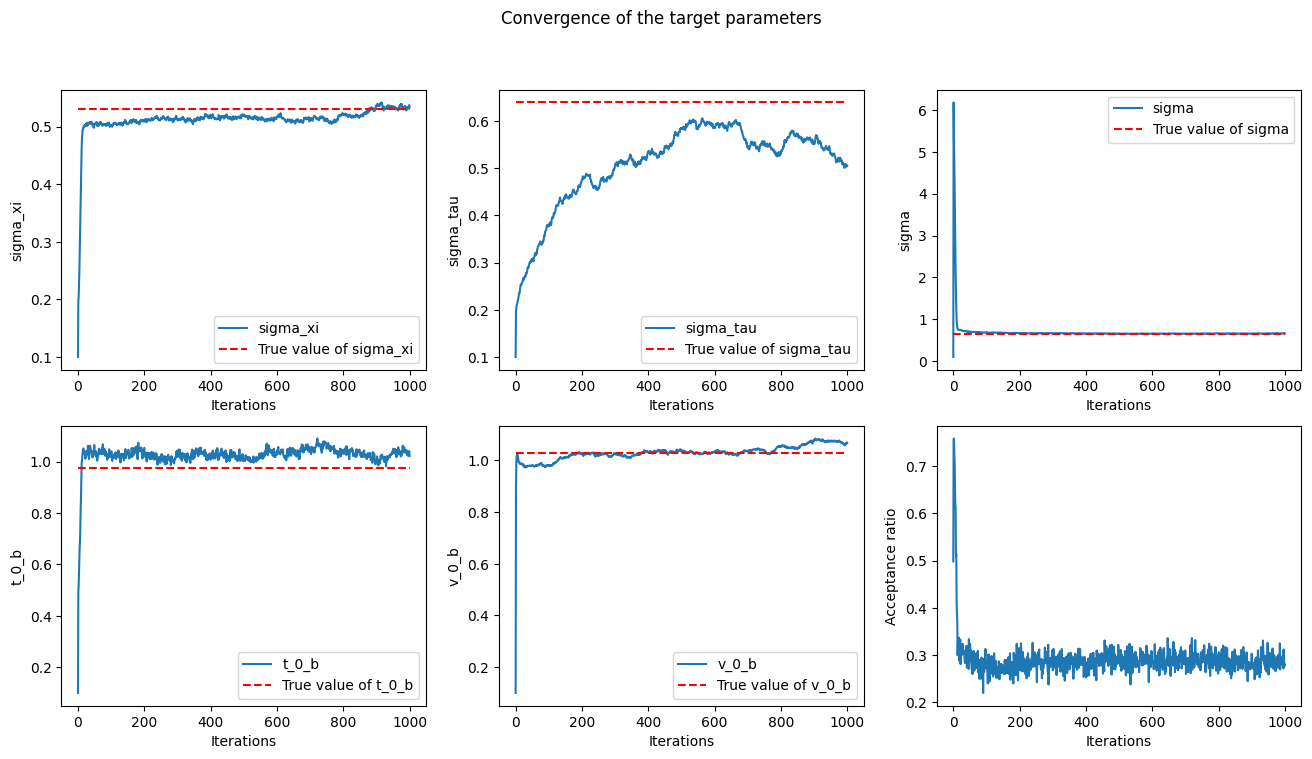

In [22]:
### Convergence of the target parameters with latent parameters initialized at 0 ###

# Target parameters are initialized at 0.1

np.random.seed(42)

z_iterates_HM_SAEM, theta_iterates_HM_SAEM, acceptance_hist_HM_SAEM = HM_SAEM(np.zeros(2*N+2), [0.1, 0.1, 0.1, 0.1, 0.1], 1000, 2e-3, target_distribution, S_curved)
theta_estimated_HM_SAEM = theta_iterates_HM_SAEM[-1]
print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)
print("\n")
print("Approximated target parameters:")
print("sigma_xi: ", theta_estimated_HM_SAEM[0])
print("sigma_tau: ", theta_estimated_HM_SAEM[1])
print("sigma: ", theta_estimated_HM_SAEM[2])
print("t_0_b: ", theta_estimated_HM_SAEM[3])
print("v_0_b: ", theta_estimated_HM_SAEM[4])
print("\n")
print("Norm of the difference between the true and the estimated parameters: ", np.linalg.norm(theta_estimated_HM_SAEM - target_theta))

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

ax[0,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[0] for theta in theta_iterates_HM_SAEM], label="sigma_xi")
ax[0,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_sigma_xi for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of sigma_xi")
ax[0,0].set_xlabel("Iterations")
ax[0,0].set_ylabel("sigma_xi")
ax[0,0].legend()

ax[0,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[1] for theta in theta_iterates_HM_SAEM], label="sigma_tau")
ax[0,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_sigma_tau for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of sigma_tau")
ax[0,1].set_xlabel("Iterations")
ax[0,1].set_ylabel("sigma_tau")
ax[0,1].legend()

ax[0,2].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[2] for theta in theta_iterates_HM_SAEM], label="sigma")
ax[0,2].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_sigma for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of sigma")
ax[0,2].set_xlabel("Iterations")
ax[0,2].set_ylabel("sigma")
ax[0,2].legend()

ax[1,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[3] for theta in theta_iterates_HM_SAEM], label="t_0_b")
ax[1,0].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_t_0_b for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of t_0_b")
ax[1,0].set_xlabel("Iterations")
ax[1,0].set_ylabel("t_0_b")
ax[1,0].legend()

ax[1,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [theta[4] for theta in theta_iterates_HM_SAEM], label="v_0_b")
ax[1,1].plot([i for i in range(len(theta_iterates_HM_SAEM))], [target_v_0_b for _ in range(len(theta_iterates_HM_SAEM))], 'k--', color='red', label="True value of v_0_b")
ax[1,1].set_xlabel("Iterations")
ax[1,1].set_ylabel("v_0_b")
ax[1,1].legend()

ax[1,2].plot([i for i in range(len(acceptance_hist))], [acceptance_hist[i] for i in range(len(acceptance_hist))], label="Acceptance ratio")
ax[1,2].set_xlabel("Iterations")
ax[1,2].set_ylabel("Acceptance ratio")

fig.suptitle("Convergence of the target parameters")
plt.show()

### 1.C – HMwG-SAEM – Hasting-Metropolis within Gibbs sampler

#### **Question 5 :** *Propose a Metropolis-Hasting within Gibbs sampler to sample from the a posteriori distribution $p(z_i | z_{pop}, y, \theta)$ for the variable $z_i = (\xi_i, \tau_i)$.*

We remind the following expression obtained in question 3:
\begin{align*}
\log p(z|y, \theta) ={}& \log p(y|z,\theta) + \log p(z|\theta) + C_{(y,\theta)} \\
={}& -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - d_i(t_{i,j}))^2 -\frac{t_0^2 - 2t_0\bar{t_0}}{2\sigma_{t_0}^2} -\frac{v_0^2 - 2v_0\bar{v_0}}{2\sigma_{v_0}^2} + \sum_{i=1}^N \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2} -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} + C_{(y,\theta)} + C
\end{align*}

First, we note that the $\{z_i\}_i$ are independent given $z_{pop}$ and $y$. Thus, we can write:
\begin{align*}
p(\{z_i\}_i | z_{pop}, y, \theta) = \prod_{i=1}^N p(z_i | z_{pop}, y, \theta)
\end{align*}
It comes that:
\begin{align*}
\log p(z_i | z_{pop}, y, \theta) &= \log p(\{z_i\}_i | z_{pop}, y, \theta) - \log p(\{z_j\}_{j \neq i} | z_{pop}, y, \theta) \\
&= \log p(z | y, \theta) - \log p(z_{pop} | y, \theta) - \log p(\{z_j\}_{j \neq i} | z_{pop}, y, \theta) \\
&= \log p(z | y, \theta) - \log p(z_{pop} | y, \theta) + C_{(\{z_j\}_{j \neq i}, y, \theta)}
\end{align*}
where $C_{(\{z_j\}_{j \neq i}, y, \theta)}$ is a constant independent of $z_i$.

Finally, using the expression of the log-likelihood, we have:
\begin{align*}
\log p(z_i | z_{pop}, y, \theta) &= \log p(z | y, \theta) - \log p(z_{pop} | y, \theta) + C_{(\{z_j\}_{j \neq i}, y, \theta)} \\
&= -\frac{1}{2\sigma^2} \sum_{j=1}^{k} (y_{i,j} - d_i(t_{i,j}))^2 +  \left\{ -\xi_i -\frac{\xi_i^2}{2\sigma_{\xi}^2} -\frac{\tau_i^2}{2\sigma_{\tau}^2}\right\} + C_{(\{z_j\}_{j \neq i}, y, \theta)} \\
\end{align*}

We can then use the Gibbs sampler to sample from the a posteriori distribution $p(z_i | z_{pop}, y, \theta)$ for the variable $z_i = (\xi_i, \tau_i)$. <br>
Given a state $z_i^{(k)} = (\xi_i^{(k)}, \tau_i^{(k)})$, we use Hasting-Metropolis to sample a new state $z_i^{(k+1)} = (\xi_i^{(k+1)}, \tau_i^{(k+1)})$ as follows:
- Sample $\tau_i^{(k+1)}$ from $p(\tau_i | \xi_i^{(k)}, z_{pop}, y, \theta)$
- Sample $\xi_i^{(k+1)}$ from $p(\xi_i | \tau_i^{(k+1)}, z_{pop}, y, \theta)$


In [23]:
@jit(nopython=True)
def target_zi_distribution(z_i, z_pop, y_i, theta):
    """
    Computes the log-likelihood according to the target distribution p(z_i | z_pop, y, theta)
    ------------------
    Parameters:
    z_i: latent variables of the individual i
    z_pop: latent variables of the population
    y_i: observations of the individual i
    theta: parameters of the target distribution
    """
    
    t = times
    k = y.shape[1]
    xi = z_i[0]
    tau = z_i[1]
    t_0 = z_pop[0]
    v_0 = z_pop[1]
    sigma_xi, sigma_tau, sigma, t_0_b, v_0_b = theta

    alpha = np.exp(xi)
    
    term_1 = 0
    for j in range(k):
        term_1 += (y_i[j] - individual_progression(t[j], xi, tau, t_0, v_0))**2
    term_1 *= - 1 / (2 * sigma**2)
    
    term_4 = - xi - 1 / (2 * sigma_xi**2) * np.power(xi, 2) - 1 / (2 * sigma_tau**2) * np.power(tau, 2)

    return term_1 + term_4

In [24]:
@jit(nopython=True)
def HMwG_zind(sigma_prop, z_0, theta, 
              target_zi_distribution, 
              max_iter = 1000):
    """
    Hasting-Metropolis within Gibbs sampler the a posteriori distribution p(z_i | z_pop, y, theta) for each individual i
    (Symmetric random walk proposal distribution)
    ------------------
    Parameters:
    z_0: initial value of the latent variables
    theta: parameters of the target distribution
    target_zi_distribution: function that computes the log-likelihood of the target distribution
    """
    z_ind = z_0[:-2]
    z_pop  = z_0[-2:]

    acceptance_rate_tau_hist = []
    acceptance_rate_xi_hist = []
    
    for i in range(N):
        # zi_0 = z_ind[[i, i+N]]
        zi_0 = z_ind[np.array([i, i+N], dtype=np.int64)]
        y_i = y[i,:]
        xi_i = zi_0[0]
        tau_i = zi_0[1]

        acceptance_rate_tau = 0
        acceptance_rate_xi = 0

        for _ in range(max_iter):

            # MH sampler for xi_i
            for _ in range(max_iter):
                loglik_zi = target_zi_distribution(zi_0, z_pop, y_i, theta)
                xi_i_temp = xi_i + sigma_prop * np.random.randn()
                zi_temp = np.array([xi_i_temp, tau_i])
                loglik_zi_temp = target_zi_distribution(zi_temp, z_pop, y_i, theta)

                acceptance_criterion = min(0, loglik_zi_temp - loglik_zi)
                acceptance_criterion = np.exp(acceptance_criterion)
                assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion for xi_i'
                if np.random.rand() < acceptance_criterion:
                    zi_0[0] = xi_i_temp
                    xi_i = xi_i_temp
                    acceptance_rate_xi += 1

            # MH sampler for tau_i
            for _ in range(max_iter):
                loglik_zi = target_zi_distribution(zi_0, z_pop, y_i, theta)
                tau_i_temp = tau_i + sigma_prop * np.random.randn()
                zi_temp = np.array([xi_i, tau_i_temp])
                loglik_zi_temp = target_zi_distribution(zi_temp, z_pop, y_i, theta)

                acceptance_criterion = min(0, loglik_zi_temp - loglik_zi)
                acceptance_criterion = np.exp(acceptance_criterion)
                assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion for tau_i'
                if np.random.rand() < acceptance_criterion:
                    zi_0[1] = tau_i_temp
                    tau_i = tau_i_temp
                    acceptance_rate_tau += 1

        z_ind[np.array([i, i+N], dtype=np.int64)] = zi_0
        acceptance_rate_tau /= max_iter**2
        acceptance_rate_xi /= max_iter**2
        acceptance_rate_tau_hist.append(acceptance_rate_tau)
        acceptance_rate_xi_hist.append(acceptance_rate_xi)

    return z_ind, acceptance_rate_xi_hist, acceptance_rate_tau_hist

In [25]:
z_ind, acceptance_rate_xi_hist, acceptance_rate_tau_hist = HMwG_zind(5e-2, z_true, target_theta, target_zi_distribution, max_iter = 1000)

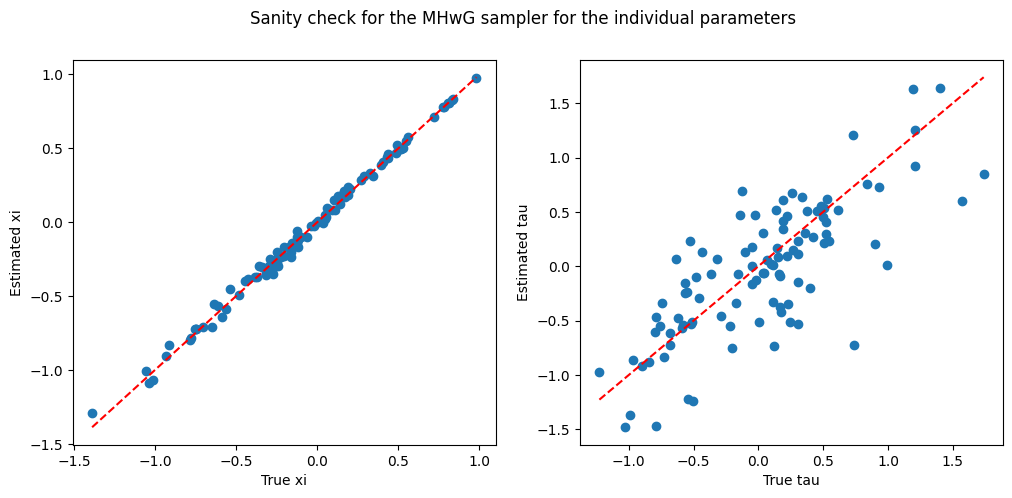

In [26]:
# Sanity check

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(xi_true, z_ind[:N], label="xi")
ax[0].plot([np.min(xi_true), np.max(xi_true)], [np.min(xi_true), np.max(xi_true)], 'k--', color='red')
ax[1].scatter(tau_true, z_ind[N:2*N], label="tau")
ax[1].plot([np.min(tau_true), np.max(tau_true)], [np.min(tau_true), np.max(tau_true)], 'k--', color='red')
ax[0].set_xlabel("True xi")
ax[0].set_ylabel("Estimated xi")
ax[1].set_xlabel("True tau")
ax[1].set_ylabel("Estimated tau")

fig.suptitle("Sanity check for the MHwG sampler for the individual parameters")
plt.show()

Average acceptance rate for xi:  0.3441812899999999
Average acceptance rate for tau:  0.88378366


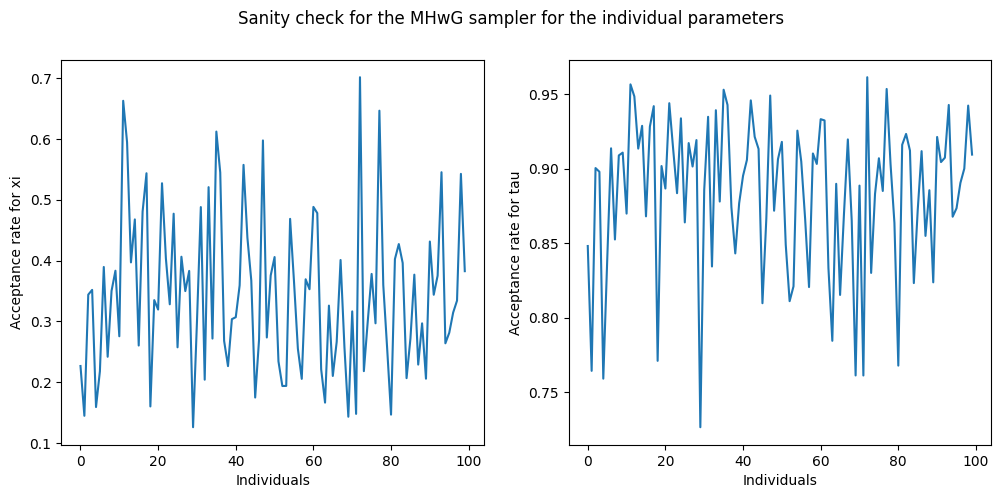

In [27]:
# Sanity check

print("Average acceptance rate for xi: ", np.mean(acceptance_rate_xi_hist))
print("Average acceptance rate for tau: ", np.mean(acceptance_rate_tau_hist))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot([i for i in range(len(acceptance_rate_xi_hist))], acceptance_rate_xi_hist, label="Acceptance rate for xi")
ax[0].set_xlabel("Individuals")
ax[0].set_ylabel("Acceptance rate for xi")
ax[1].plot([i for i in range(len(acceptance_rate_tau_hist))], acceptance_rate_tau_hist, label="Acceptance rate for tau")
ax[1].set_xlabel("Individuals")
ax[1].set_ylabel("Acceptance rate for tau")

fig.suptitle("Sanity check for the MHwG sampler for the individual parameters")
plt.show()


As compared to the classical Metropolis-Hasting algorithm, the parameter $\sigma_{prop}$ has been increased from $2e-3$ to $5e-2$. By doing so, the acceptance rate for $\xi_i$ is between 0.2 and 0.4. However, the acceptance rate for $\tau_i$ is much higher, and it seemed impossible to decrease it without reducing drastically the acceptance rate for $\xi_i$. <br>

#### **Question 6 :** *Likewise, propose a HMwG sampler for the a posteriori distribution $p(z_{pop} | \{z_i\}_i,y,\theta)$ of the variable $z_{pop} = (t_0, v_0)$.*

Following the same reasoning as in question 5, we have:
\begin{align*}
\log p(z_{pop} | \{z_i\}_i,y,\theta) &= \log p(z | y, \theta) - \log p(\{z_i\}_i | y, \theta) + C_{(\{z_i\}_i, y, \theta)} \\
&= -\frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k} (y_{i,j} - d_i(t_{i,j}))^2 -\frac{t_0^2 - 2t_0\bar{t_0}}{2\sigma_{t_0}^2} -\frac{v_0^2 - 2v_0\bar{v_0}}{2\sigma_{v_0}^2} + C_{(\{z_i\}_i, y, \theta)} \\
\end{align*}

We can then use the Gibbs sampler to sample from the a posteriori distribution $p(z_{pop} | \{z_i\}_i,y,\theta)$ of the variable $z_{pop} = (t_0, v_0)$. <br>
Given a state $z_{pop}^{(k)} = (t_0^{(k)}, v_0^{(k)})$, we use Hasting-Metropolis to sample a new state $z_{pop}^{(k+1)} = (t_0^{(k+1)}, v_0^{(k+1)})$ as follows:
- Sample $t_0^{(k+1)}$ from $p(t_0 | v_0^{(k)}, \{z_i\}_i,y,\theta)$
- Sample $v_0^{(k+1)}$ from $p(v_0 | t_0^{(k+1)}, \{z_i\}_i,y,\theta)$

In [28]:
@jit(nopython=True)
def target_zpop_distribution(z_pop, z_ind, theta):
    """
    Computes the log-likelihood according to the target distribution p(z_pop | z_i, y, theta)
    ------------------
    Parameters:
    z_pop: latent variables of the population
    z_ind: latent variables of the individuals
    theta: parameters of the target distribution
    """
    
    t = times
    N = y.shape[0]
    k = y.shape[1]
    xi = z_ind[:N]
    tau = z_ind[N:2*N]
    t_0 = z_pop[-2]
    v_0 = z_pop[-1]
    sigma_xi, sigma_tau, sigma, t_0_b, v_0_b = theta

    alpha = np.exp(xi)
    
    term_1 = 0
    for i in range(N):
        for j in range(k):
            term_1 += (y[i,j] - individual_progression(t[j], xi[i], tau[i], t_0, v_0))**2
    term_1 *= - 1 / (2 * sigma**2)
    
    term_2 = - (t_0**2 - 2 * t_0 * t_0_b) / (2 * sigma_t_0**2)
    term_3 = - (v_0**2 - 2 * v_0 * v_0_b) / (2 * sigma_v_0**2)

    return term_1 + term_2 + term_3

In [29]:
@jit(nopython=True)
def HMwG_zpop(sigma_prop, z_0, theta, 
              target_zpop_distribution, 
              max_iter = 1000):
    """
    Hasting-Metropolis within Gibbs sampler the a posteriori distribution p(z_pop | z_i, y, theta)
    (Symmetric random walk proposal distribution)
    ------------------
    Parameters:
    z_0: initial value of the latent variables
    theta: parameters of the target distribution
    target_zpop_distribution: function that computes the log-likelihood of the target distribution
    """
    z_ind = z_0[:-2]
    z_pop  = z_0[-2:]

    t_0 = z_pop[0]
    v_0 = z_pop[1]

    acceptance_rate_t0 = 0
    acceptance_rate_v0 = 0

    # Gibbs loop
    for _ in range(max_iter):
        
        for _ in range(max_iter):
            # MH sampler for t_0
            loglik_zpop = target_zpop_distribution(z_pop, z_ind, theta)
            t_0_temp = t_0 + sigma_prop * np.random.randn()
            z_pop_temp = np.array([t_0_temp, v_0])
            loglik_zpop_temp = target_zpop_distribution(z_pop_temp, z_ind, theta)

            acceptance_criterion = min(0, loglik_zpop_temp - loglik_zpop)
            acceptance_criterion = np.exp(acceptance_criterion)
            assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion for t_0'
            if np.random.rand() < acceptance_criterion:
                z_pop[0] = t_0_temp
                t_0 = t_0_temp
                acceptance_rate_t0 += 1

            # MH sampler for v_0
        for _ in range(max_iter):
            loglik_zpop = target_zpop_distribution(z_pop, z_ind, theta)
            v_0_temp = v_0 + sigma_prop * np.random.randn()
            z_pop_temp = np.array([t_0, v_0_temp])
            loglik_zpop_temp = target_zpop_distribution(z_pop_temp, z_ind, theta)

            acceptance_criterion = min(0, loglik_zpop_temp - loglik_zpop)
            acceptance_criterion = np.exp(acceptance_criterion)
            assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion for v_0'
            if np.random.rand() < acceptance_criterion:
                z_pop[1] = v_0_temp
                v_0 = v_0_temp
                acceptance_rate_v0 += 1
        
    
    acceptance_rate_t0 /= max_iter**2
    acceptance_rate_v0 /= max_iter**2

    return z_pop, acceptance_rate_t0, acceptance_rate_v0

In [30]:
z_pop, acceptance_rate_t0, acceptance_rate_v0 = HMwG_zpop(5e-2, z_true, target_theta, target_zpop_distribution, max_iter = 1000)

In [31]:
# Sanity check

print("Average acceptance rate for t_0: ", acceptance_rate_t0)
print("Average acceptance rate for v_0: ", acceptance_rate_v0)
print("\n")
print("Latent parameters:")
print("t_0: ", t_0_true)
print("v_0: ", v_0_true)
print("\n")
print("Approximated latent parameters:")
print("t_0: ", z_pop[-2])
print("v_0: ", z_pop[-1])


Average acceptance rate for t_0:  0.292074
Average acceptance rate for v_0:  0.029397


Latent parameters:
t_0:  1.0262577196062053
v_0:  1.0140776991028952


Approximated latent parameters:
t_0:  1.0927459923549372
v_0:  1.0161334076550212


As compared to the classical Metropolis-Hasting algorithm, the parameter $\sigma_{prop}$ has been increased from $2e-3$ to $5e-2$ here as well. By doing so, the acceptance rate for $t_0$ is between 0.2 and 0.4. However, the acceptance rate for $v_0$ is much lower, and it seemed impossible to increase it without increasing drastically the acceptance rate for $t_0$. <br>

#### **Question 7 :** *Using the results of the two previous questions, implement the HMwG-SAEM in order to find the MAP.*

In [32]:
@jit(nopython=True)
def HMwG_SAEM(z_0, theta_0, max_iter, sigma_prop, S_curved, 
              target_zi_distribution, target_zpop_distribution):
    """
    Hybrid Monte Carlo - Stochastic Approximation EM algorithm with Gibbs sampling
    --------------
    Parameters:
    z_0:  latent variables
    theta_0: parameters of the target distribution
    max_iter: maximum number of iterations
    sigma_prop: standard deviation of the proposal distribution
    S_curved: function that computes the S function
    target_zi_distribution: function that computes the log-likelihood of the target distribution for the individual parameters
    target_zpop_distribution: function that computes the log-likelihood of the target distribution for the population parameters
    """
    theta_iterates = [np.array(theta_0)]
    z_iterates = [z_0]
    acceptance_hist_xi = np.empty(0)
    acceptance_hist_tau = np.empty(0)
    acceptance_hist_t0 = np.empty(0)
    acceptance_hist_v0 = np.empty(0)
    burn_in = int(max_iter / 2)
    steps = np.ones(max_iter)
    for i in range(burn_in, max_iter):
        steps[i] = (i + 1 - burn_in)**(-0.6)
    theta = np.array(theta_0)
    
    for i in range(max_iter):
        # if (i+1) % 1000 == 0:
            # print(f"{i+1} iterations done")
            # assert np.mean(acceptance_hist_xi) >= 0.2, "Acceptance ratio for xi below 20%, need to reduce sigma_prop"
            # assert np.mean(acceptance_hist_xi) <= 0.4, "Acceptance ratio for xi above 40%, need to increase sigma_prop"
            # assert np.mean(acceptance_hist_tau) >= 0.2, "Acceptance ratio for tau below 20%, need to reduce sigma_prop"
            # assert np.mean(acceptance_hist_tau) <= 0.4, "Acceptance ratio for tau above 40%, need to increase sigma_prop"
            # assert np.mean(acceptance_hist_t0) >= 0.2, "Acceptance ratio for t_0 below 20%, need to reduce sigma_prop"
            # assert np.mean(acceptance_hist_t0) <= 0.4, "Acceptance ratio for t_0 above 40%, need to increase sigma_prop"
            # assert np.mean(acceptance_hist_v0) >= 0.2, "Acceptance ratio for v_0 below 20%, need to reduce sigma_prop"
            # assert np.mean(acceptance_hist_v0) <= 0.4, "Acceptance ratio for v_0 above 40%, need to increase sigma_prop"

        S = S_curved(z_0)
        z_ind = z_0[:-2]
        ## Simulation
        z_pop_new, acceptance_t0, acceptance_v0 = HMwG_zpop(sigma_prop, z_0, theta, target_zpop_distribution, max_iter = max_iter)
        z_new = np.concatenate((z_ind, z_pop_new))
        z_ind_new, acceptance_xi, acceptance_tau = HMwG_zind(sigma_prop, z_new, theta, target_zi_distribution, max_iter = max_iter)
        z_new = np.concatenate((z_ind_new, z_pop_new))
        acceptance_hist_xi = np.append(acceptance_hist_xi, np.mean(np.array(acceptance_xi)))
        acceptance_hist_tau = np.append(acceptance_hist_tau, np.mean(np.array(acceptance_tau)))
        acceptance_hist_t0 = np.append(acceptance_hist_t0, acceptance_t0)
        acceptance_hist_v0 = np.append(acceptance_hist_v0, acceptance_v0)
        ## Stochastic approximation
        S_new = S + steps[i] * (S_curved(z_new) - S)
        ## Maximization step
        theta_new = maximization_step(z_new, theta, S_new)
        ## Update
        z_0 = z_new
        theta = theta_new
        z_iterates.append(z_0)
        theta_iterates.append(theta)
        
    return z_iterates, theta_iterates, acceptance_hist_xi, acceptance_hist_tau, acceptance_hist_t0, acceptance_hist_v0
    

In [33]:
# Timing of the algorithm

start = time.time()
z_iterates, theta_iterates, acceptance_hist_xi, acceptance_hist_tau, acceptance_hist_t0, acceptance_hist_v0 = HMwG_SAEM(z_true, target_theta, 100, 5e-2, S_curved, target_zi_distribution, target_zpop_distribution)
end = time.time()

time_HMwG_SAEM = end - start

print(f"Execution time of the HMwG_SAEM algorithm: {time_HMwG_SAEM} seconds")

Execution time of the HMwG_SAEM algorithm: 31.919638872146606 seconds


##### **Sanity checks**

Latent parameters:
t_0:  1.0262577196062053
v_0:  1.0140776991028952
Approximated latent parameters:
t_0:  1.0131735001335822
v_0:  1.075390352434491


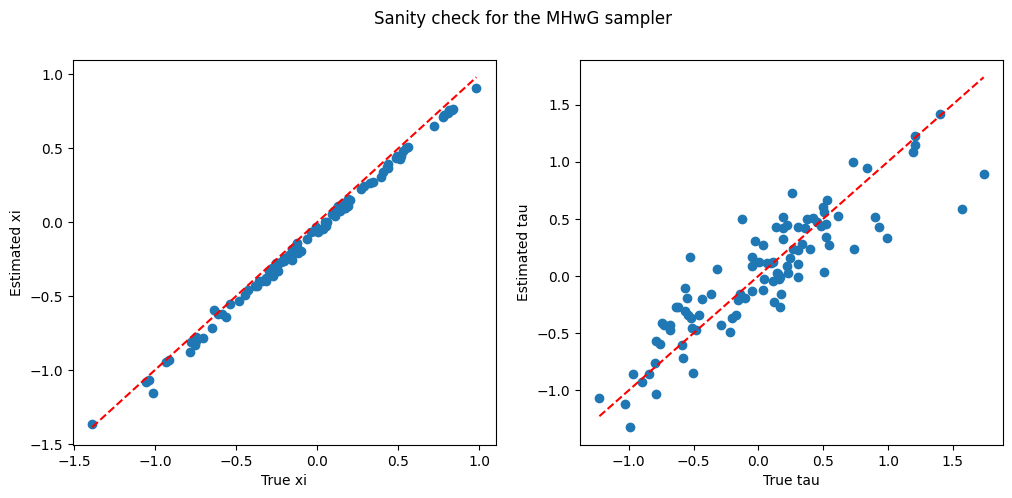

In [34]:
### Convergence of the latent parameters given the target parameters ###

# Latent parameters are initialized at 0

z_iterates, theta_iterates, acceptance_hist_xi, acceptance_hist_tau, acceptance_hist_t0, acceptance_hist_v0 = HMwG_SAEM(np.zeros(2*N+2), target_theta, 100, 5e-2, S_curved, target_zi_distribution, target_zpop_distribution)
z_estimated = np.mean(z_iterates, axis=0)
print("Latent parameters:")
print("t_0: ", t_0_true)
print("v_0: ", v_0_true)
print("Approximated latent parameters:")
print("t_0: ", z_estimated[-2])
print("v_0: ", z_estimated[-1])


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(xi_true, z_estimated[:N], label="xi")
ax[0].plot([np.min(xi_true), np.max(xi_true)], [np.min(xi_true), np.max(xi_true)], 'k--', color='red')
ax[1].scatter(tau_true, z_estimated[N:2*N], label="tau")
ax[1].plot([np.min(tau_true), np.max(tau_true)], [np.min(tau_true), np.max(tau_true)], 'k--', color='red')
ax[0].set_xlabel("True xi")
ax[0].set_ylabel("Estimated xi")
ax[1].set_xlabel("True tau")
ax[1].set_ylabel("Estimated tau")

fig.suptitle("Sanity check for the MHwG sampler")
plt.show()

We observe a good convergence of the parameters $t_0$ and $v_0$ towards their true values. <br>
The plots of the parameters $\xi_i$ and $\tau_i$ show a good convergence as well, with a bit more variance for $\tau$, probably due to the fact that the acceptance rate for $\tau$ is higher than for $\xi$.

In [35]:
### Convergence of the target parameters given the latent parameters ###

# Target parameters are initialized at 0.1

np.random.seed(42)

z_iterates_HMwG_SAEM, theta_iterates_HMwG_SAEM, acceptance_hist_xi, acceptance_hist_tau, acceptance_hist_t0, acceptance_hist_v0 = HMwG_SAEM(z_true, [0.1, 0.1, 0.1, 0.1, 0.1], 100, 5e-2, S_curved, target_zi_distribution, target_zpop_distribution)
theta_estimated_HMwG_SAEM = theta_iterates_HMwG_SAEM[-1]
print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)
print("\n")
print("Approximated target parameters:")
print("sigma_xi: ", theta_estimated_HMwG_SAEM[0])
print("sigma_tau: ", theta_estimated_HMwG_SAEM[1])
print("sigma: ", theta_estimated_HMwG_SAEM[2])
print("t_0_b: ", theta_estimated_HMwG_SAEM[3])
print("v_0_b: ", theta_estimated_HMwG_SAEM[4])
print('\n')
print("Norm of the difference between the true and the estimated parameters: ", np.linalg.norm(theta_estimated_HMwG_SAEM - target_theta))

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


Approximated target parameters:
sigma_xi:  0.5076772915297676
sigma_tau:  0.605383257304992
sigma:  0.6574753222419012
t_0_b:  0.9926818897813462
v_0_b:  1.0086818098931754


Norm of the difference between the true and the estimated parameters:  0.04760731419850337


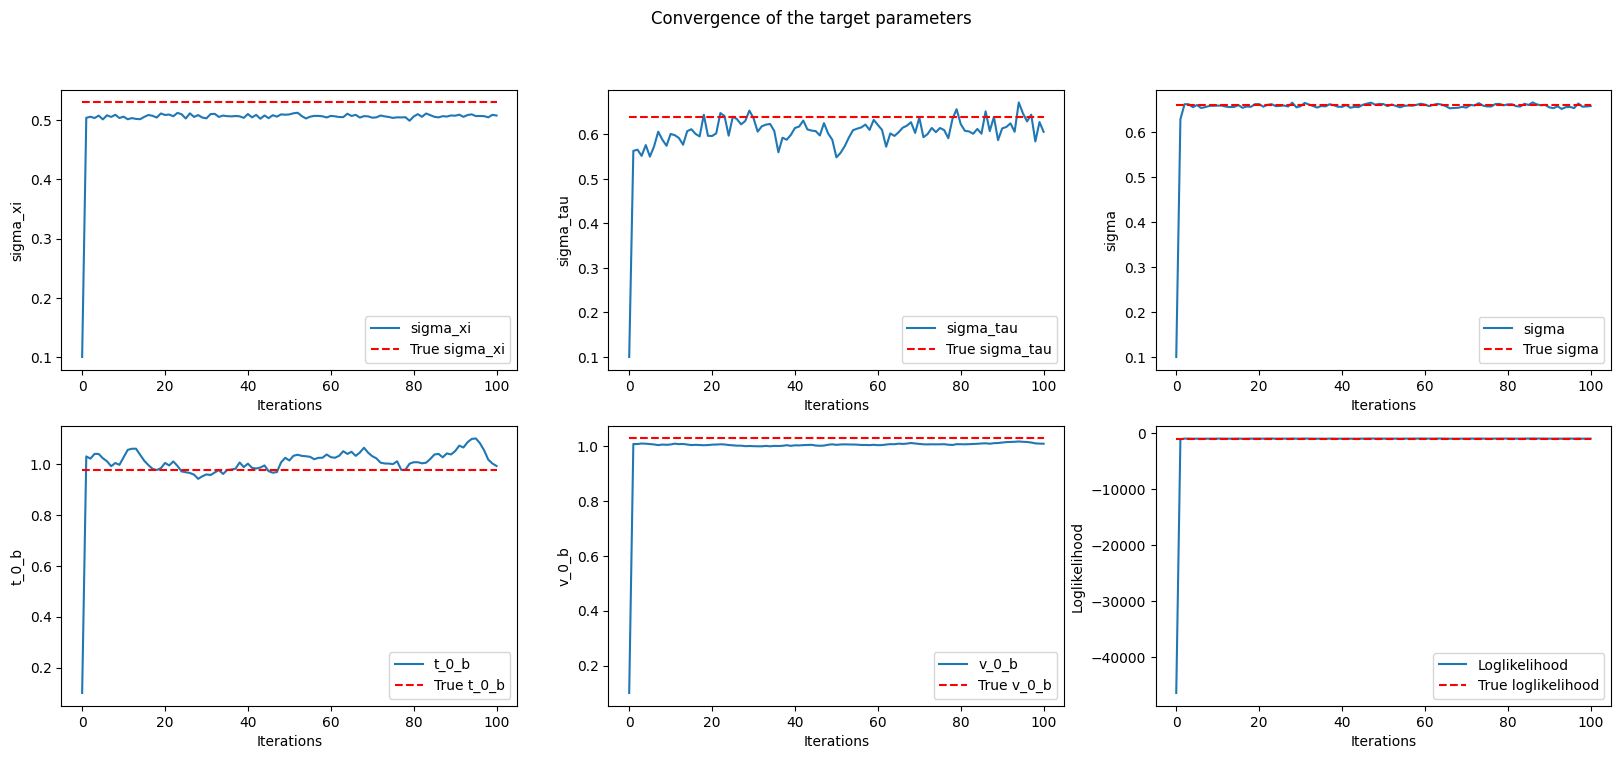

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[0] for theta in theta_iterates_HMwG_SAEM], label="sigma_xi")
ax[0,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_sigma_xi for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True sigma_xi")
ax[0,0].set_xlabel("Iterations")
ax[0,0].set_ylabel("sigma_xi")
ax[0,0].legend()

ax[0,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[1] for theta in theta_iterates_HMwG_SAEM], label="sigma_tau")
ax[0,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_sigma_tau for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True sigma_tau")
ax[0,1].set_xlabel("Iterations")
ax[0,1].set_ylabel("sigma_tau")
ax[0,1].legend()

ax[0,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[2] for theta in theta_iterates_HMwG_SAEM], label="sigma")
ax[0,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_sigma for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True sigma")
ax[0,2].set_xlabel("Iterations")
ax[0,2].set_ylabel("sigma")
ax[0,2].legend()

ax[1,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[3] for theta in theta_iterates_HMwG_SAEM], label="t_0_b")
ax[1,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_t_0_b for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True t_0_b")
ax[1,0].set_xlabel("Iterations")
ax[1,0].set_ylabel("t_0_b")
ax[1,0].legend()

ax[1,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[4] for theta in theta_iterates_HMwG_SAEM], label="v_0_b")
ax[1,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_v_0_b for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True v_0_b")
ax[1,1].set_xlabel("Iterations")
ax[1,1].set_ylabel("v_0_b")
ax[1,1].legend()

ax[1,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_distribution(z_true, theta) for theta in theta_iterates_HMwG_SAEM], label="Loglikelihood")
ax[1,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_distribution(z_true, target_theta) for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True loglikelihood")
ax[1,2].set_xlabel("Iterations")
ax[1,2].set_ylabel("Loglikelihood")
ax[1,2].legend()

fig.suptitle("Convergence of the target parameters")
plt.show()

The convergence towards the target parameters is really good, and considerably faster than expected: the algorithm seeems to converge in approximately 200 iterations. <br>

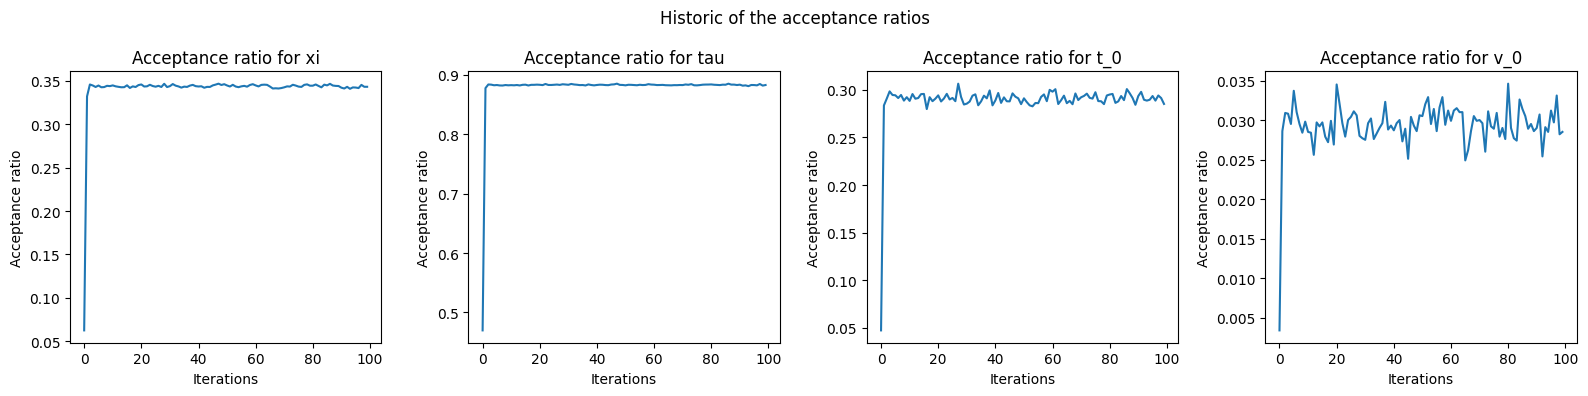

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].plot([i for i in range(len(acceptance_hist_xi))], [acceptance_hist_xi[i] for i in range(len(acceptance_hist_xi))], label="Acceptance ratio for xi")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Acceptance ratio")
ax[0].set_title("Acceptance ratio for xi")

ax[1].plot([i for i in range(len(acceptance_hist_tau))], [acceptance_hist_tau[i] for i in range(len(acceptance_hist_tau))], label="Acceptance ratio for tau")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Acceptance ratio")
ax[1].set_title("Acceptance ratio for tau")

ax[2].plot([i for i in range(len(acceptance_hist_t0))], [acceptance_hist_t0[i] for i in range(len(acceptance_hist_t0))], label="Acceptance ratio for t_0")
ax[2].set_xlabel("Iterations")
ax[2].set_ylabel("Acceptance ratio")
ax[2].set_title("Acceptance ratio for t_0")

ax[3].plot([i for i in range(len(acceptance_hist_v0))], [acceptance_hist_v0[i] for i in range(len(acceptance_hist_v0))], label="Acceptance ratio for v_0")
ax[3].set_xlabel("Iterations")
ax[3].set_ylabel("Acceptance ratio")
ax[3].set_title("Acceptance ratio for v_0")

fig.suptitle("Historic of the acceptance ratios")
fig.tight_layout()
plt.show()

As detailed when considering the Metropolis-Hasting within Gibbs, we chose a parameter $\sigma_{prop}$ such that the acceptance ratio is between 20% and 40% for $\xi_i$ and $t_0$.
However, the acceptance ratio for $\tau_i$ is much higher and the acceptance ratio for $v_0$ is much lower. <br> 

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


Approximated target parameters:
sigma_xi:  0.5145601799609891
sigma_tau:  0.5901655787054925
sigma:  0.6584349644726947
t_0_b:  1.0780061154744789
v_0_b:  1.026566812632591


Norm of the difference between the true and the estimated parameters:  0.11370416045713622


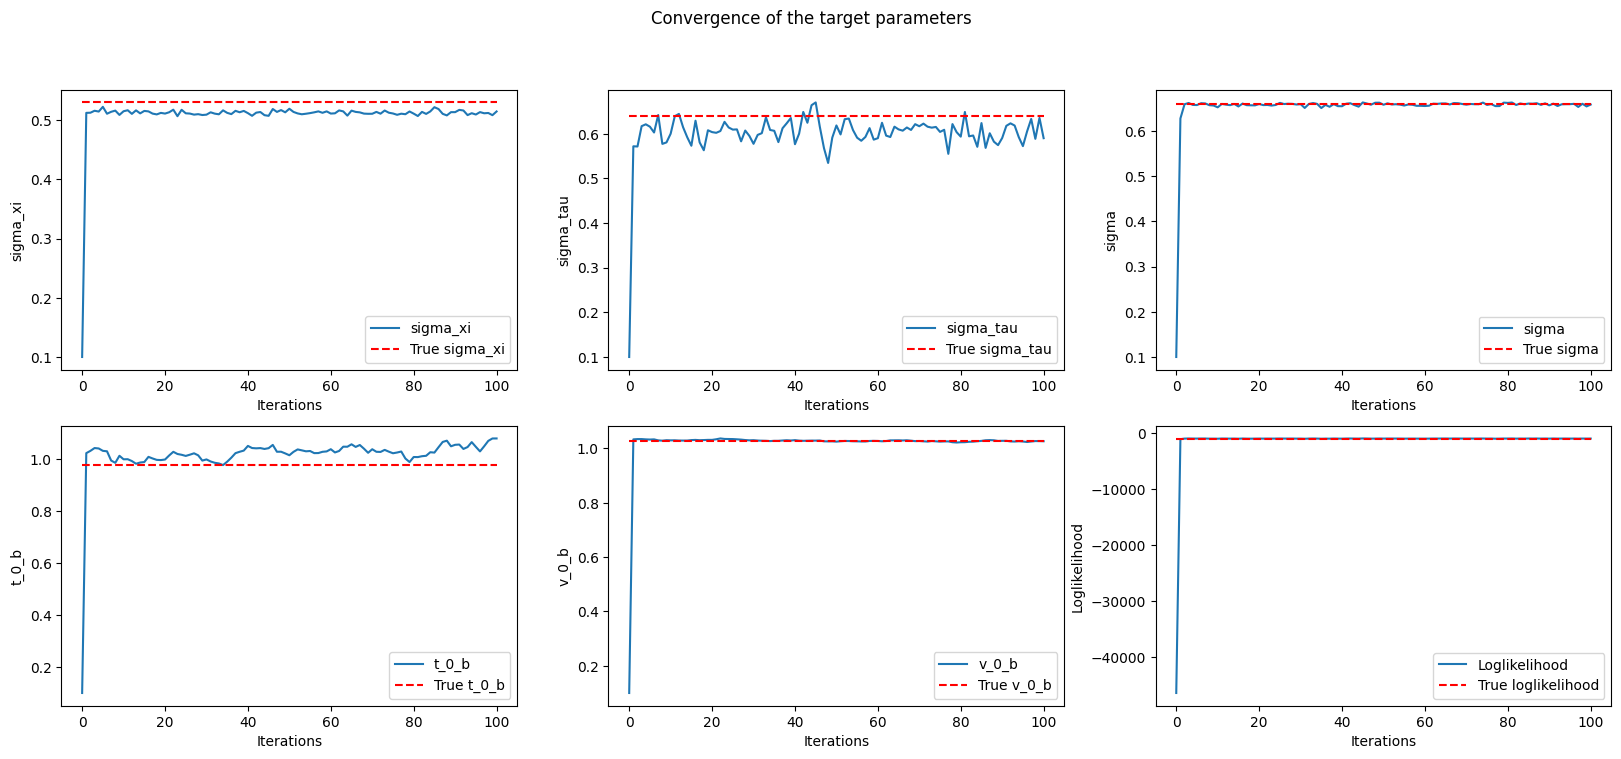

In [38]:
### Convergence of the target parameters with the latent parameters initialized at 0 ###

# Target parameters are initialized at 0.1

np.random.seed(42)

(z_iterates_HMwG_SAEM, theta_iterates_HMwG_SAEM, acceptance_hist_xi, acceptance_hist_tau, 
 acceptance_hist_t0, acceptance_hist_v0) = HMwG_SAEM(np.zeros(2*N+2), [0.1, 0.1, 0.1, 0.1, 0.1], 100, 5e-2, S_curved, 
                                                     target_zi_distribution, target_zpop_distribution)
theta_estimated_HMwG_SAEM = theta_iterates_HMwG_SAEM[-1]
print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)
print("\n")
print("Approximated target parameters:")
print("sigma_xi: ", theta_estimated_HMwG_SAEM[0])
print("sigma_tau: ", theta_estimated_HMwG_SAEM[1])
print("sigma: ", theta_estimated_HMwG_SAEM[2])
print("t_0_b: ", theta_estimated_HMwG_SAEM[3])
print("v_0_b: ", theta_estimated_HMwG_SAEM[4])
print('\n')
print("Norm of the difference between the true and the estimated parameters: ", np.linalg.norm(theta_estimated_HMwG_SAEM - target_theta))

fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[0] for theta in theta_iterates_HMwG_SAEM], label="sigma_xi")
ax[0,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_sigma_xi for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True sigma_xi")
ax[0,0].set_xlabel("Iterations")
ax[0,0].set_ylabel("sigma_xi")
ax[0,0].legend()

ax[0,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[1] for theta in theta_iterates_HMwG_SAEM], label="sigma_tau")
ax[0,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_sigma_tau for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True sigma_tau")
ax[0,1].set_xlabel("Iterations")
ax[0,1].set_ylabel("sigma_tau")
ax[0,1].legend()

ax[0,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[2] for theta in theta_iterates_HMwG_SAEM], label="sigma")
ax[0,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_sigma for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True sigma")
ax[0,2].set_xlabel("Iterations")
ax[0,2].set_ylabel("sigma")
ax[0,2].legend()

ax[1,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[3] for theta in theta_iterates_HMwG_SAEM], label="t_0_b")
ax[1,0].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_t_0_b for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True t_0_b")
ax[1,0].set_xlabel("Iterations")
ax[1,0].set_ylabel("t_0_b")
ax[1,0].legend()

ax[1,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [theta[4] for theta in theta_iterates_HMwG_SAEM], label="v_0_b")
ax[1,1].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_v_0_b for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True v_0_b")
ax[1,1].set_xlabel("Iterations")
ax[1,1].set_ylabel("v_0_b")
ax[1,1].legend()

ax[1,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_distribution(z_true, theta) for theta in theta_iterates_HMwG_SAEM], label="Loglikelihood")
ax[1,2].plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [target_distribution(z_true, target_theta) for _ in range(len(theta_iterates_HMwG_SAEM))], 'k--', color='red', label="True loglikelihood")
ax[1,2].set_xlabel("Iterations")
ax[1,2].set_ylabel("Loglikelihood")
ax[1,2].legend()

fig.suptitle("Convergence of the target parameters")
plt.show()

#### **Question 8 :** *Explain what is the advantages of a Block Gibbs sampler over a "one-at-a-time" Gibbs sampler for our model.*

The first SAEM implemented used a Metroplis-Hasting sampler to sample from the a posteriori distribution $p(z | y, \theta)$ of the latent variable $z = (z_i, z_{pop})_{i \in \{1,N\}} = (\xi_i, \tau_i, t_0, v_0)_{i \in \{1,N\}} \in \mathbb{R}^{2N+2}$. <br>

The second SAEM implemented used a Metropolis-Hasting within Gibbs sampler to sample from the a posteriori distribution $p(z_i | z_{pop}, y, \theta)$ for the variable $z_i = (\xi_i, \tau_i)$ and from the a posteriori distribution $p(z_{pop} | \{z_i\}_i,y,\theta)$ of the variable $z_{pop} = (t_0, v_0)$. The Gibbs method was such that for each variable in both couples, we used a Metropolis-Hasting sampler to sample from the a posteriori distribution of the variable given the other variable and the other parameters (cf. previous questions). We thus moved from one sample in $\mathbb{R}^{2N+2}$ in the first SAEM to $2N+2$ samples in $\mathbb{R}$.

The Block Gibbs sampler is a particular case of the Gibbs sampler, where the variables are grouped into blocks and the variables in each block are sampled simultaneously. <br>
In our case, we compose $N+1$ blocks of variables: one block for each $z_i$ and one block for $z_{pop}$. This final version make us move to $N+1$ samples in $\mathbb{R}^{2}$, thus dividing by a factor of 2 the number of samples required. This will come handy as we noticed that the HwG-SAEM algorithm took around 3 times as much that the HW-SAEM algorithm to run (even by dividing the number of iterations by a factor of 10).

#### **Question 9 :** *Implement a Block HMwG sampler by choosing a block for the fixed effects and a block by individuals, in the SAEM framework. Compare your results with the classical Gibbs sampler and comment.*

In [39]:
@jit(nopython=True)
def Block_HMwG_zind(sigma_prop, z_0, theta, 
              target_zi_distribution, 
              max_iter = 1000):
    """
    Block Hasting-Metropolis within Gibbs sampler the a posteriori distribution p(z_i | z_pop, y, theta) for each individual i
    (Symmetric random walk proposal distribution)
    ------------------
    Parameters:
    z_0: initial value of the latent variables
    theta: parameters of the target distribution
    target_zi_distribution: function that computes the log-likelihood of the target distribution
    """
    z_ind = z_0[:-2]
    z_pop  = z_0[-2:]

    acceptance_rate_ind = []
    
    for i in range(N):
        zi_0 = z_ind[np.array([i, i+N], dtype=np.int64)]
        y_i = y[i,:]
        xi_i = zi_0[0]
        tau_i = zi_0[1]

        acceptance_rate_z_i = 0

        # MH sampler for z_i = (xi_i, tau_i)
        for _ in range(max_iter):
            loglik_zi = target_zi_distribution(zi_0, z_pop, y_i, theta)
            xi_i_temp = xi_i + sigma_prop * np.random.randn()
            tau_i_temp = tau_i + sigma_prop * np.random.randn()
            zi_temp = np.array([xi_i_temp, tau_i_temp])
            loglik_zi_temp = target_zi_distribution(zi_temp, z_pop, y_i, theta)

            acceptance_criterion = min(0, loglik_zi_temp - loglik_zi)
            acceptance_criterion = np.exp(acceptance_criterion)
            assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion'
            if np.random.rand() < acceptance_criterion:
                zi_0[0] = xi_i_temp
                zi_0[1] = tau_i_temp
                xi_i = xi_i_temp
                tau_i = tau_i_temp
                acceptance_rate_z_i += 1

        z_ind[np.array([i, i+N], dtype=np.int64)] = zi_0
        acceptance_rate_z_i /= max_iter
        acceptance_rate_ind.append(acceptance_rate_z_i)

    return z_ind, acceptance_rate_ind

In [40]:
z_ind, acceptance_rate_ind = Block_HMwG_zind(5e-2, z_true, target_theta, target_zi_distribution, max_iter = 5000)
np.mean(acceptance_rate_ind)

0.337448

In [41]:
@jit(nopython=True)
def Block_HMwG_zpop(sigma_prop, z_0, theta, 
              target_zpop_distribution, 
              max_iter = 1000):
    """
    Block Hasting-Metropolis within Gibbs sampler the a posteriori distribution p(z_pop | z_i, y, theta)
    (Symmetric random walk proposal distribution)
    ------------------
    Parameters:
    z_0: initial value of the latent variables
    theta: parameters of the target distribution
    target_zpop_distribution: function that computes the log-likelihood of the target distribution
    """
    z_ind = z_0[:-2]
    z_pop  = z_0[-2:]

    t_0 = z_pop[0]
    v_0 = z_pop[1]

    acceptance_rate_zpop = 0

    # MH sampler for z_pop = (t_0, v_0)
    for _ in range(max_iter):
        loglik_zpop = target_zpop_distribution(z_pop, z_ind, theta)
        t_0_temp = t_0 + sigma_prop * np.random.randn()
        v_0_temp = v_0 + sigma_prop * np.random.randn()
        z_pop_temp = np.array([t_0_temp, v_0_temp])
        loglik_zpop_temp = target_zpop_distribution(z_pop_temp, z_ind, theta)

        acceptance_criterion = min(0, loglik_zpop_temp - loglik_zpop)
        acceptance_criterion = np.exp(acceptance_criterion)
        assert acceptance_criterion >=0 and acceptance_criterion <=1, 'Error in acceptance criterion for t_0'
        if np.random.rand() < acceptance_criterion:
            z_pop[0] = t_0_temp
            z_pop[1] = v_0_temp
            t_0 = t_0_temp
            v_0 = v_0_temp
            acceptance_rate_zpop += 1

    acceptance_rate_zpop /= max_iter

    return z_pop, acceptance_rate_zpop

In [42]:
z_pop, acceptance_rate_zpop = Block_HMwG_zpop(5e-3, z_true, target_theta, target_zpop_distribution, max_iter = 1000)
acceptance_rate_zpop

0.256

In [43]:
@jit(nopython=True)
def Block_HMwG_SAEM(z_0, theta_0, max_iter, sigma_prop, S_curved, 
              target_zi_distribution, target_zpop_distribution):
    """
    Hybrid Monte Carlo - Stochastic Approximation EM algorithm with Gibbs sampling
    --------------
    Parameters:
    z_0:  latent variables
    theta_0: parameters of the target distribution
    max_iter: maximum number of iterations
    sigma_prop: standard deviation of the proposal distribution
    S_curved: function that computes the S function
    target_zi_distribution: function that computes the log-likelihood of the target distribution for the individual parameters
    target_zpop_distribution: function that computes the log-likelihood of the target distribution for the population parameters
    """
    theta_iterates = [np.array(theta_0)]
    z_iterates = [z_0]
    acceptance_hist_zind = np.empty(0)
    acceptance_hist_zpop = np.empty(0)
    burn_in = int(max_iter / 2)
    steps = np.ones(max_iter)
    for i in range(burn_in, max_iter):
        steps[i] = (i + 1 - burn_in)**(-0.6)
    theta = np.array(theta_0)
    
    for i in range(max_iter):
        # if (i+1) % 1000 == 0:
            # print(f"{i+1} iterations done")
            # assert np.mean(acceptance_hist_xi) >= 0.2, "Acceptance ratio for xi below 20%, need to reduce sigma_prop"
            # assert np.mean(acceptance_hist_xi) <= 0.4, "Acceptance ratio for xi above 40%, need to increase sigma_prop"

        S = S_curved(z_0)
        z_ind = z_0[:-2]
        ## Simulation
        z_pop_new, acceptance_zpop = Block_HMwG_zpop(sigma_prop, z_0, theta, target_zpop_distribution, max_iter = max_iter)
        z_new = np.concatenate((z_ind, z_pop_new))
        z_ind_new, acceptance_zind = Block_HMwG_zind(sigma_prop, z_new, theta, target_zi_distribution, max_iter = max_iter)
        z_new = np.concatenate((z_ind_new, z_pop_new))
        acceptance_hist_zind = np.append(acceptance_hist_zind, np.mean(np.array(acceptance_zind)))
        acceptance_hist_zpop = np.append(acceptance_hist_zpop, acceptance_zpop)
        ## Stochastic approximation
        S_new = S + steps[i] * (S_curved(z_new) - S)
        ## Maximization step
        theta_new = maximization_step(z_new, theta, S_new)
        ## Update
        z_0 = z_new
        theta = theta_new
        z_iterates.append(z_0)
        theta_iterates.append(theta)
        
    return z_iterates, theta_iterates, acceptance_hist_zind, acceptance_hist_zpop
    

In [44]:
# Timing of the algorithm

start = time.time()
z_iterates, theta_iterates, acceptance_hist_zind, acceptance_hist_zpop = Block_HMwG_SAEM(z_true, target_theta, 1000, 5e-2, 
                                                                                         S_curved, target_zi_distribution, target_zpop_distribution)
end = time.time()

time_Block_HMwG_SAEM = end - start

print(f"Execution time of the Block HMwG_SAEM algorithm: {time_Block_HMwG_SAEM} seconds")

Execution time of the Block HMwG_SAEM algorithm: 18.530877828598022 seconds


##### **Sanity checks**

Latent parameters:
t_0:  1.0262577196062053
v_0:  1.0140776991028952
Approximated latent parameters:
t_0:  1.0536383771013724
v_0:  1.1378784773833257


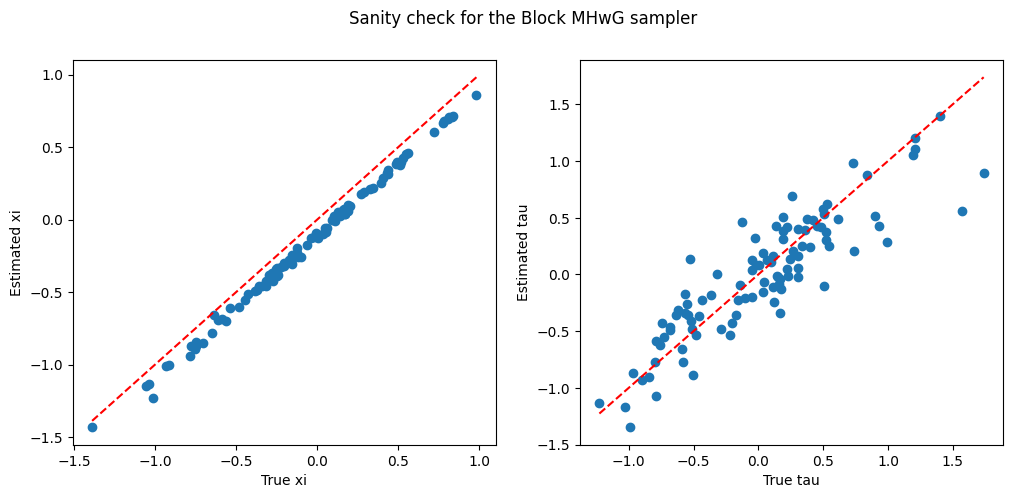

In [45]:
### Convergence of the latent parameters given the target parameters ###

# Latent parameters are initialized at 0

z_iterates, theta_iterates, acceptance_hist_zind, acceptance_hist_zpop = Block_HMwG_SAEM(np.zeros(2*N+2), target_theta, 1000, 5e-2, 
                                                                                         S_curved, target_zi_distribution, target_zpop_distribution)
z_estimated = np.mean(z_iterates, axis=0)
print("Latent parameters:")
print("t_0: ", t_0_true)
print("v_0: ", v_0_true)
print("Approximated latent parameters:")
print("t_0: ", z_estimated[-2])
print("v_0: ", z_estimated[-1])


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(xi_true, z_estimated[:N], label="xi")
ax[0].plot([np.min(xi_true), np.max(xi_true)], [np.min(xi_true), np.max(xi_true)], 'k--', color='red')
ax[1].scatter(tau_true, z_estimated[N:2*N], label="tau")
ax[1].plot([np.min(tau_true), np.max(tau_true)], [np.min(tau_true), np.max(tau_true)], 'k--', color='red')
ax[0].set_xlabel("True xi")
ax[0].set_ylabel("Estimated xi")
ax[1].set_xlabel("True tau")
ax[1].set_ylabel("Estimated tau")

fig.suptitle("Sanity check for the Block MHwG sampler")
plt.show()

In [46]:
### Convergence of the target parameters given the latent parameters ###

# Target parameters are initialized at 0.1

np.random.seed(42)

z_iterates_Block_HMwG_SAEM, theta_iterates_Block_HMwG_SAEM, acceptance_hist_zind, acceptance_hist_zpop = Block_HMwG_SAEM(z_true, [0.1, 0.1, 0.1, 0.1, 0.1], 1000, 5e-2, 
                                                                                                                   S_curved, target_zi_distribution, target_zpop_distribution)
theta_estimated_Block_HMwG_SAEM = theta_iterates_Block_HMwG_SAEM[-1]
print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)
print("\n")
print("Approximated target parameters:")
print("sigma_xi: ", theta_estimated_Block_HMwG_SAEM[0])
print("sigma_tau: ", theta_estimated_Block_HMwG_SAEM[1])
print("sigma: ", theta_estimated_Block_HMwG_SAEM[2])
print("t_0_b: ", theta_estimated_Block_HMwG_SAEM[3])
print("v_0_b: ", theta_estimated_Block_HMwG_SAEM[4])
print('\n')
print("Norm of the difference between the true and the estimated parameters: ", np.linalg.norm(theta_estimated_Block_HMwG_SAEM - target_theta))

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


Approximated target parameters:
sigma_xi:  0.5261716946513703
sigma_tau:  0.6014694078762626
sigma:  0.6583895444873119
t_0_b:  1.0322192749595236
v_0_b:  1.0473042766085758


Norm of the difference between the true and the estimated parameters:  0.07008381654410392


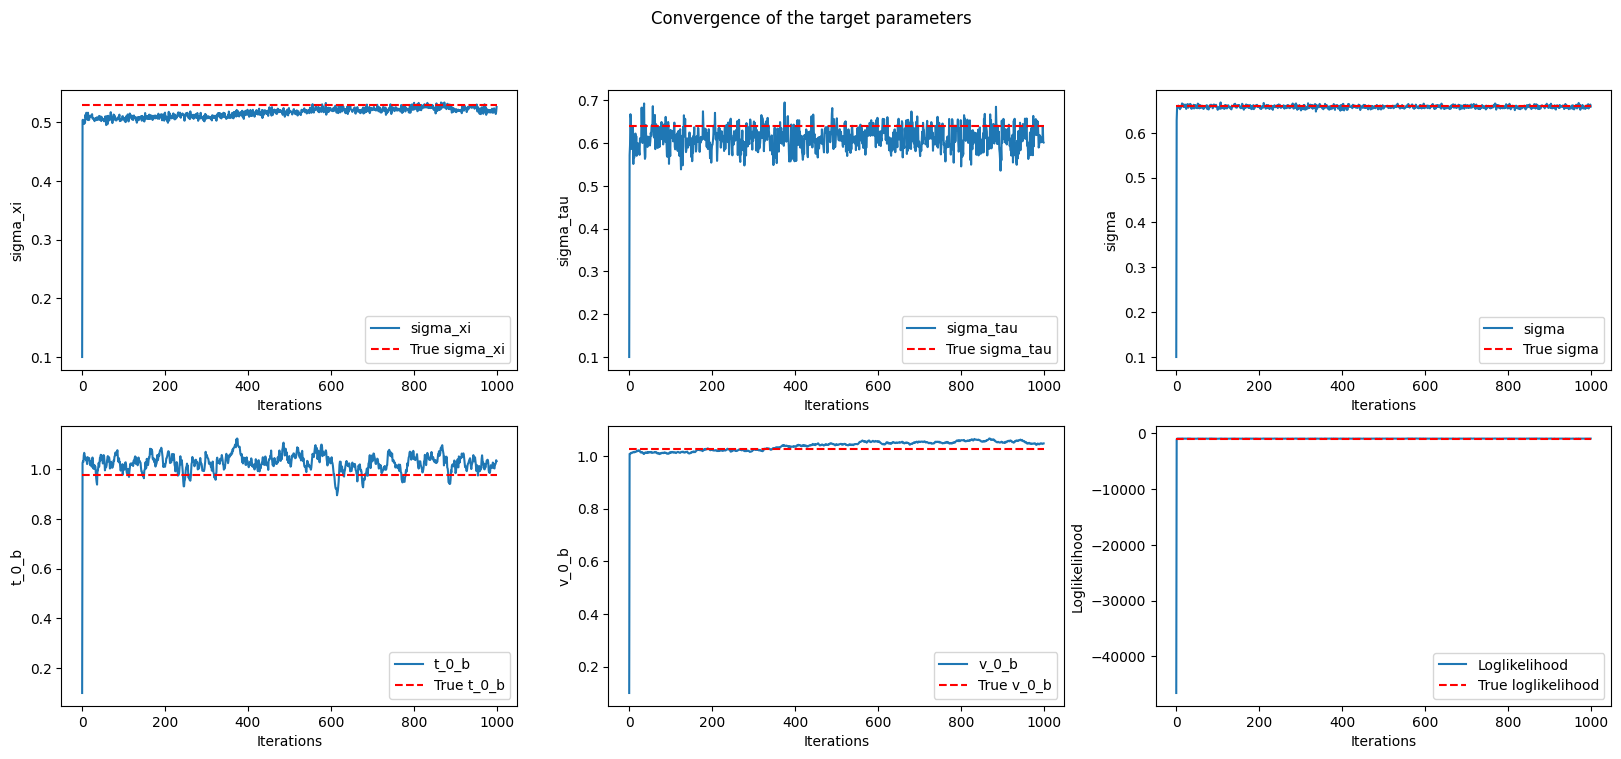

In [47]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[0] for theta in theta_iterates_Block_HMwG_SAEM], label="sigma_xi")
ax[0,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_sigma_xi for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True sigma_xi")
ax[0,0].set_xlabel("Iterations")
ax[0,0].set_ylabel("sigma_xi")
ax[0,0].legend()

ax[0,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[1] for theta in theta_iterates_Block_HMwG_SAEM], label="sigma_tau")
ax[0,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_sigma_tau for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True sigma_tau")
ax[0,1].set_xlabel("Iterations")
ax[0,1].set_ylabel("sigma_tau")
ax[0,1].legend()

ax[0,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[2] for theta in theta_iterates_Block_HMwG_SAEM], label="sigma")
ax[0,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_sigma for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True sigma")
ax[0,2].set_xlabel("Iterations")
ax[0,2].set_ylabel("sigma")
ax[0,2].legend()

ax[1,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[3] for theta in theta_iterates_Block_HMwG_SAEM], label="t_0_b")
ax[1,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_t_0_b for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True t_0_b")
ax[1,0].set_xlabel("Iterations")
ax[1,0].set_ylabel("t_0_b")
ax[1,0].legend()

ax[1,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[4] for theta in theta_iterates_Block_HMwG_SAEM], label="v_0_b")
ax[1,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_v_0_b for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True v_0_b")
ax[1,1].set_xlabel("Iterations")
ax[1,1].set_ylabel("v_0_b")
ax[1,1].legend()

ax[1,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_distribution(z_true, theta) for theta in theta_iterates_Block_HMwG_SAEM], label="Loglikelihood")
ax[1,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_distribution(z_true, target_theta) for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True loglikelihood")
ax[1,2].set_xlabel("Iterations")
ax[1,2].set_ylabel("Loglikelihood")
ax[1,2].legend()

fig.suptitle("Convergence of the target parameters")
plt.show()

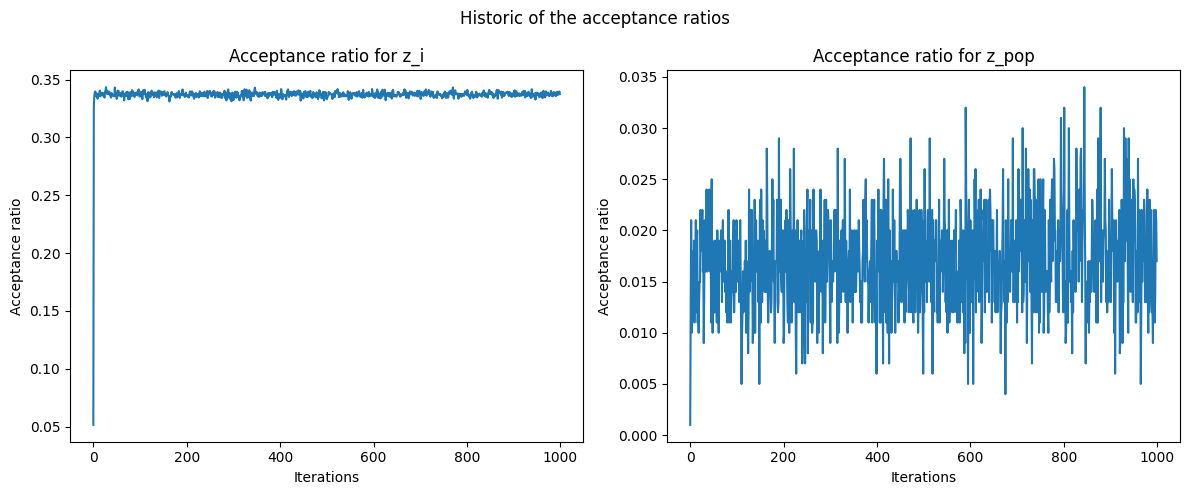

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot([i for i in range(len(acceptance_hist_zind))], [acceptance_hist_zind[i] for i in range(len(acceptance_hist_zind))], label="Acceptance ratio for z_i")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Acceptance ratio")
ax[0].set_title("Acceptance ratio for z_i")

ax[1].plot([i for i in range(len(acceptance_hist_zpop))], [acceptance_hist_zpop[i] for i in range(len(acceptance_hist_zpop))], label="Acceptance ratio for z_pop")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Acceptance ratio")
ax[1].set_title("Acceptance ratio for z_pop")

fig.suptitle("Historic of the acceptance ratios")
fig.tight_layout()
plt.show()

Target parameters:
sigma_xi:  0.5297892487600045
sigma_tau:  0.6392426821613534
sigma:  0.6590538116821373
t_0_b:  0.976586304305082
v_0_b:  1.0279041292200137


Approximated target parameters:
sigma_xi:  0.5239764668943105
sigma_tau:  0.5838315498807443
sigma:  0.6612149998868816
t_0_b:  1.0179950041590062
v_0_b:  1.064012591472444


Norm of the difference between the true and the estimated parameters:  0.07827741831410387


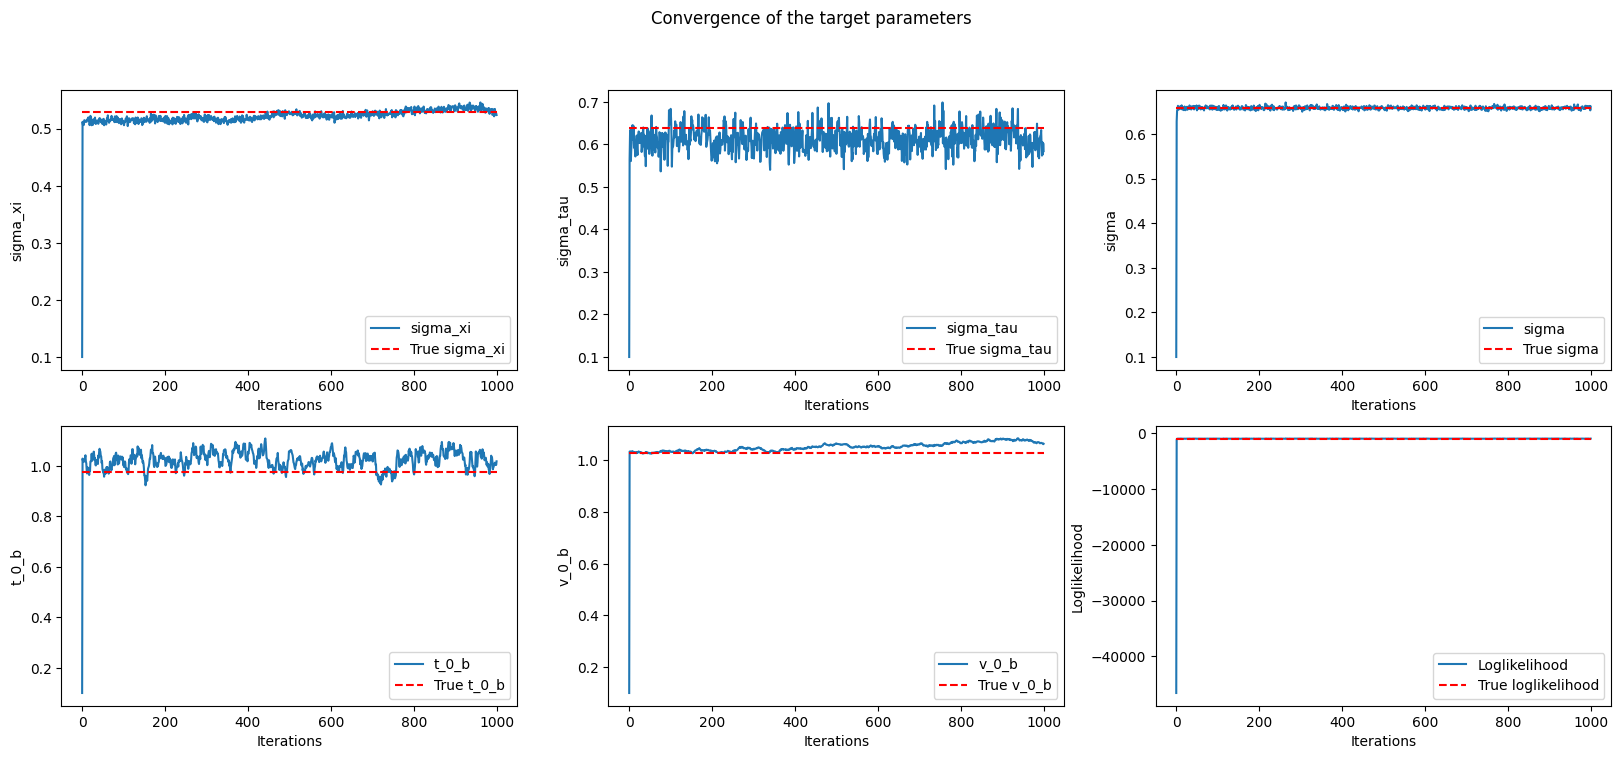

In [49]:
### Convergence of the target parameters with the latent parameters initialized at 0 ###

# Target parameters are initialized at 0.1

np.random.seed(42)

z_iterates_Block_HMwG_SAEM, theta_iterates_Block_HMwG_SAEM, acceptance_hist_zind, acceptance_hist_zpop = Block_HMwG_SAEM(np.zeros(2*N+2), [0.1, 0.1, 0.1, 0.1, 0.1], 1000, 5e-2, 
                                                                                                                   S_curved, target_zi_distribution, target_zpop_distribution)
theta_estimated_Block_HMwG_SAEM = theta_iterates_Block_HMwG_SAEM[-1]
print("Target parameters:")
print("sigma_xi: ", target_sigma_xi)
print("sigma_tau: ", target_sigma_tau)
print("sigma: ", target_sigma)
print("t_0_b: ", target_t_0_b)
print("v_0_b: ", target_v_0_b)
print("\n")
print("Approximated target parameters:")
print("sigma_xi: ", theta_estimated_Block_HMwG_SAEM[0])
print("sigma_tau: ", theta_estimated_Block_HMwG_SAEM[1])
print("sigma: ", theta_estimated_Block_HMwG_SAEM[2])
print("t_0_b: ", theta_estimated_Block_HMwG_SAEM[3])
print("v_0_b: ", theta_estimated_Block_HMwG_SAEM[4])
print('\n')
print("Norm of the difference between the true and the estimated parameters: ", np.linalg.norm(theta_estimated_Block_HMwG_SAEM - target_theta))

fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[0] for theta in theta_iterates_Block_HMwG_SAEM], label="sigma_xi")
ax[0,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_sigma_xi for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True sigma_xi")
ax[0,0].set_xlabel("Iterations")
ax[0,0].set_ylabel("sigma_xi")
ax[0,0].legend()

ax[0,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[1] for theta in theta_iterates_Block_HMwG_SAEM], label="sigma_tau")
ax[0,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_sigma_tau for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True sigma_tau")
ax[0,1].set_xlabel("Iterations")
ax[0,1].set_ylabel("sigma_tau")
ax[0,1].legend()

ax[0,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[2] for theta in theta_iterates_Block_HMwG_SAEM], label="sigma")
ax[0,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_sigma for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True sigma")
ax[0,2].set_xlabel("Iterations")
ax[0,2].set_ylabel("sigma")
ax[0,2].legend()

ax[1,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[3] for theta in theta_iterates_Block_HMwG_SAEM], label="t_0_b")
ax[1,0].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_t_0_b for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True t_0_b")
ax[1,0].set_xlabel("Iterations")
ax[1,0].set_ylabel("t_0_b")
ax[1,0].legend()

ax[1,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [theta[4] for theta in theta_iterates_Block_HMwG_SAEM], label="v_0_b")
ax[1,1].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_v_0_b for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True v_0_b")
ax[1,1].set_xlabel("Iterations")
ax[1,1].set_ylabel("v_0_b")
ax[1,1].legend()

ax[1,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_distribution(z_true, theta) for theta in theta_iterates_Block_HMwG_SAEM], label="Loglikelihood")
ax[1,2].plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [target_distribution(z_true, target_theta) for _ in range(len(theta_iterates_Block_HMwG_SAEM))], 'k--', color='red', label="True loglikelihood")
ax[1,2].set_xlabel("Iterations")
ax[1,2].set_ylabel("Loglikelihood")
ax[1,2].legend()

fig.suptitle("Convergence of the target parameters")
plt.show()

Convergence of the target parameters when the latent parameters are initialized at 0:


Average difference between the true and the estimated parameters for HM-SAEM:  0.1726001213723482  || time:  8.827580213546753
Average difference between the true and the estimated parameters for HMwG-SAEM:  0.08088526951873622  || time:  31.919638872146606
Average difference between the true and the estimated parameters for Block HMwG-SAEM:  0.0725177975093848  || time:  18.530877828598022


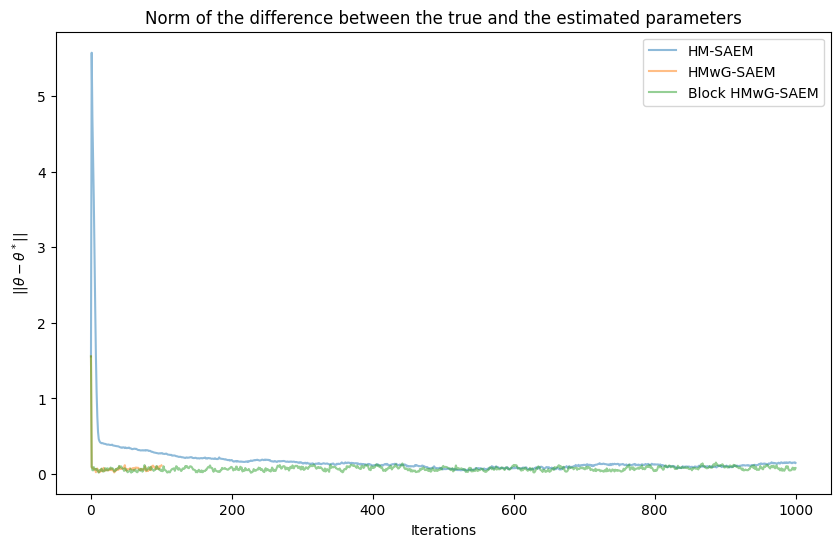

In [53]:
### Comparison of the algorithms ###

# Convergence of the target parameters when the latent parameters are initialized at 0

print("Convergence of the target parameters when the latent parameters are initialized at 0:")
print("\n")
print("Average difference between the true and the estimated parameters for HM-SAEM: ", np.mean([np.linalg.norm(theta - target_theta) for theta in theta_iterates_HM_SAEM]), " || time: ", time_HM_SAEM)
print("Average difference between the true and the estimated parameters for HMwG-SAEM: ", np.mean([np.linalg.norm(theta - target_theta) for theta in theta_iterates_HMwG_SAEM]), " || time: ", time_HMwG_SAEM)
print("Average difference between the true and the estimated parameters for Block HMwG-SAEM: ", np.mean([np.linalg.norm(theta - target_theta) for theta in theta_iterates_Block_HMwG_SAEM]), " || time: ", time_Block_HMwG_SAEM)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot([i for i in range(len(theta_iterates_HM_SAEM))], [np.linalg.norm(theta - target_theta) for theta in theta_iterates_HM_SAEM], label="HM-SAEM", alpha=0.5)
ax.plot([i for i in range(len(theta_iterates_HMwG_SAEM))], [np.linalg.norm(theta - target_theta) for theta in theta_iterates_HMwG_SAEM], label="HMwG-SAEM", alpha=0.5)
ax.plot([i for i in range(len(theta_iterates_Block_HMwG_SAEM))], [np.linalg.norm(theta - target_theta) for theta in theta_iterates_Block_HMwG_SAEM], label="Block HMwG-SAEM", alpha=0.5)
ax.set_xlabel("Iterations")
ax.set_ylabel(r'$|| \theta - \theta^* ||$')
ax.set_title("Norm of the difference between the true and the estimated parameters")
ax.legend()

plt.show()

As expected, the execution time of the Block HMwG-SAEM is significantly reduced as compared to the execution time of the HMwG-SAEM (the latter was stopped after only 100 iterations for reasonable timing). <br>
We also note a better mean approximation of the parameters: one reason for this could be that when sampling the latent variables one at a time, our choice of having the same $\sigma_{prop}$ for all the variables came with the limitation that the acceptance rate of some variables was outside the optimal range, thus leading to a less efficient sampling. This phenomenon was less problematic with the Block HMwG-SAEM as variables were considered in blocks. <br>

The Metropolis-Hasting within Gibbs samplers are generally more efficient when the space of latent variables is high-dimensional: updating the parameters one at a time then allows to circumvent a low acceptance rate in the MH algorithm. This comes at a computational cost as detailed in question 8. In our case, the most efficient algorithm was the Block HMwG-SAEM which seems to offer a good balance between a faster approximation than the classical MH-SAEM and a shorter execution time than HMwG-SAEM (here only 100 iterations considered). <br>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## **Exercise 2**: Multiplicative Hasting-Metropolis

Let $f$ be the density of some distribution $\pi_f$ supported on $]−1,1[$. We consider the *multiplicative Hasting-Metropolis algorithm* defined as follows.

Let $X$ be the current state of the Markov chain.
- $\epsilon \sim \pi_f$ and $\mathcal{B} \sim \mathcal{B}er(1/2)$
- $Y = \begin{cases}
X \epsilon & \text{if } \mathcal{B} = 1 \\
X / \epsilon & \text{if } \mathcal{B} = 0
\end{cases}$
- $X^{(k+1)} = Y$ with probability $\alpha(X,Y)$

where $\alpha(X,Y) = \min \left\{ 1, \frac{q(X|Y)\pi(Y)}{q(Y|X)\pi(X)} \right\}$.

#### **Question 1 :** *Given a current state $x$, determine the proposal kernel $q(x,dy)$ of the MCMC step described above.*

Let $h$ be a bounded Borel-measurable function. We recall the following:
\begin{align*}
\mathbb{E}[h(Y)|X = x] = \int h(y) q(x, dy)
\end{align*}

We take such a function $h$ and compute:
\begin{align*}
\mathbb{E}[h(Y)|X = x] &= \mathbb{E}[h(X \epsilon)|X = x] \mathbb{P}(\mathcal{B} = 1|X = x) + \mathbb{E}[h(X / \epsilon)|X = x] \mathbb{P}(\mathcal{B} = 0|X = x) \\
&= \mathbb{E}[h(x \epsilon)] \frac{1}{2} + \mathbb{E}[h(x / \epsilon)] \frac{1}{2} \\
&= \frac{1}{2} \left[ \int_{-1}^1 h(x \epsilon) f(\epsilon) d\epsilon + \int_{-1}^{0^-} h(x / \epsilon) f(\epsilon) d\epsilon + \int_{0^+}^1 h(x / \epsilon) f(\epsilon) d\epsilon \right]\\
\end{align*}

Let $x = 0$. We have:
\begin{align*}
\mathbb{E}[h(Y)|X = 0] &= \frac{1}{2} \mathbb{E}[h(0)] + \frac{1}{2} \mathbb{E}[h(0)] = \mathbb{E}[h(0)] = h(0). \\
\end{align*}
If $x=0$ at some point, then the chain will become blocked in this state as it will stay at $0$ for all the following iterations. We discard this case in further analysis. <br>

Let $x \neq 0$. We consider the change of variable $\alpha = x \epsilon$ in the first integral and $\beta = x / \epsilon$ in the second integral. <br>
We distinguish between two cases impacting the last two integrals' bounds:
- If $x > 0$:
\begin{align*}
\mathbb{E}[h(Y)|X = x] &= \frac{1}{2} \left[\int_{-x}^x h(\alpha) \frac{1}{x} f\left(\frac{\alpha}{x}\right) d\alpha + \int_{-x}^{ -\infty} h(\beta) \frac{-x}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta + \int_{+\infty}^x h(\beta) \frac{-x}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta \right]\\
&=\frac{1}{2} \left[ \int_{-x}^x h(\alpha) \frac{1}{x} f\left(\frac{\alpha}{x}\right) d\alpha + \int_{-\infty}^{-x} h(\beta) \frac{x}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta + \int_x^{+\infty} h(\beta) \frac{x}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta \right]\\
&= \frac{1}{2} \int h(y) \left( \frac{1}{x} f\left(\frac{y}{x}\right) \mathbb{1}_{]-x,x[}(y) + \frac{x}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{]-\infty,-x[}(y) + \frac{x}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{]x,+\infty[}(y) \right) dy \\
&= \frac{1}{2} \int h(y) \left( \frac{1}{x} f\left(\frac{y}{x}\right) \mathbb{1}_{]-x,x[}(y) + \frac{x}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{]-\infty,-x[ \cup ]x,+\infty[}(y) \right) dy \\
&= \frac{1}{2} \int h(y) \left( \frac{1}{|x|} f\left(\frac{y}{x}\right) \mathbb{1}_{]-|x|,|x|[}(y) + \frac{|x|}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{]-\infty,-|x|[ \cup ]|x|,+\infty[}(y) \right) dy \\
\end{align*}

- If $x < 0$:
\begin{align*}
\mathbb{E}[h(Y)|X = x] &= \frac{1}{2} \left[ \int_{-x}^x h(\alpha) \frac{1}{x} f(\frac{\alpha}{x}) d\alpha + \int_{-x}^{+\infty} h(\beta) \frac{-x}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta + \int_{- \infty}^x h(\beta) \frac{-x}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta \right]\\
&= \frac{1}{2} \left[ \int_{|x|}^{-|x|} h(\alpha) \frac{1}{-|x|} f\left(\frac{\alpha}{x}\right) d\alpha + \int_{|x|}^{+\infty} h(\beta) \frac{|x|}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta + \int_{- \infty}^{-|x|} h(\beta) \frac{|x|}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta \right]\\
&= \frac{1}{2} \left[ \int_{-|x|}^{|x|} h(\alpha) \frac{1}{|x|} f\left(\frac{\alpha}{x}\right) d\alpha + \int_{|x|}^{+\infty} h(\beta) \frac{|x|}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta + \int_{- \infty}^{-|x|} h(\beta) \frac{|x|}{\beta^2} f\left(\frac{x}{\beta}\right) d\beta \right]\\
&= \frac{1}{2} \int h(y) \left( \frac{1}{|x|} f\left(\frac{y}{x}\right) \mathbb{1}_{]-|x|,|x|[}(y) + \frac{|x|}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{]-\infty,-|x|[ \cup ]|x|,+\infty[}(y) \right) dy \\
\end{align*}

Therefore, by identification, for all $x \in \mathbb{R}^*$, we can write the proposal kernel $q(x,dy)$ as:
\begin{align*}
q(x,dy) &= \frac{1}{2} \left( \frac{1}{|x|} f\left(\frac{y}{x}\right) \mathbb{1}_{]-|x|,|x|[}(y) + \frac{|x|}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{]-\infty,-|x|[ \cup ]|x|,+\infty[}(y) \right) dy \\
&= \frac{1}{2} \left( \frac{1}{|x|} f\left(\frac{y}{x}\right) \mathbb{1}_{|y|<|x|} + \frac{|x|}{y^2} f\left(\frac{x}{y}\right) \mathbb{1}_{|x|<|y|} \right) dy
\end{align*}



#### **Question 2 :** *Compute the acceptation ratio $\alpha(x,y)$ so that the chain has a given distribution $\pi$ as invariant distribution.*

We write the acceptation ratio $\alpha(x,y)$ as follows:
\begin{align*}
\alpha(X,Y) &= \min \left\{ 1, \frac{q(X|Y)\pi(Y)}{q(Y|X)\pi(X)} \right\} \\
\end{align*}
Defining $\alpha$ as such ensures that the chain has $\pi$ as invariant distribution.

We compute the following:
\begin{align*}
\frac{q(X|Y)}{q(Y|X)} &= \frac{\frac{1}{2} \left( \frac{1}{|Y|} f\left(\frac{X}{Y}\right) \mathbb{1}_{]-|Y|,|Y|[}(X) + \frac{|Y|}{X^2} f\left(\frac{Y}{X}\right) \mathbb{1}_{]-\infty,-|Y|[ \cup ]|Y|,+\infty[}(X) \right)}{\frac{1}{2} \left( \frac{1}{|X|} f\left(\frac{Y}{X}\right) \mathbb{1}_{]-|X|,|X|[}(Y) + \frac{|X|}{Y^2} f\left(\frac{X}{Y}\right) \mathbb{1}_{]-\infty,-|X|[ \cup ]|X|,+\infty[}(Y) \right)} \\
&= \frac{\frac{1}{|Y|} f\left(\frac{X}{Y}\right) \mathbb{1}_{|X|<|Y|} + \frac{|Y|}{X^2} f\left(\frac{Y}{X}\right) \mathbb{1}_{|Y|<|X|}}{\frac{1}{|X|} f\left(\frac{Y}{X}\right) \mathbb{1}_{|Y|<|X|} + \frac{|X|}{Y^2} f\left(\frac{X}{Y}\right) \mathbb{1}_{|X|<|Y|}} \\
&= \frac{|Y|}{|X|} \left(\frac{ \frac{|X|}{Y^2} f\left(\frac{X}{Y}\right) \mathbb{1}_{|X|<|Y|} + \frac{1}{|X|}f\left(\frac{Y}{X}\right) \mathbb{1}_{|Y|<|X|}} {\frac{1}{|X|} f\left(\frac{Y}{X}\right) \mathbb{1}_{|Y|<|X|} + \frac{|X|}{Y^2} f\left(\frac{X}{Y}\right) \mathbb{1}_{|X|<|Y|}} \right) \\
&= \frac{|Y|}{|X|}
\end{align*}

As a result, we have:
\begin{align*}
\alpha(X,Y) &= \min \left\{ 1, \frac{q(X|Y)\pi(Y)}{q(Y|X)\pi(X)} \right\} \\
&= \min \left\{ 1, \frac{|Y|}{|X|} \frac{\pi(Y)}{\pi(X)} \right\} \\
\end{align*}

#### **Question 3 :** *Implement this sampler, where $f$ is given by the uniform distribution on $] − 1, 1[$, for two different target distributions : the first one being a distribution from which we can sample using the inverse transform method and the second one being of your choice.*

In [48]:
def multiplicative_hm(X_0, target_distribution, max_iter):

    states = [X_0]
    acceptance = 0

    for _ in range(max_iter):
        eps = np.random.uniform(-1, 1)
        ber = 0
        if np.random.rand() <= 1. / 2.:
            ber = 1
        
        if ber == 1:
            y = eps * X_0
        else:
            y = X_0 / (eps+1e-6)
        
        alpha = min(1, np.abs(y) * target_distribution(y) / (np.abs(X_0) * target_distribution(X_0)))

        if np.random.rand() < alpha:
            X_0 = y
            states.append(X_0)
            acceptance += 1

    acceptance /= max_iter

    return states, acceptance

##### **Rayleigh distribution**

Building on the first homework, the Rayleigh distribution is defined by the following probability density function:
\begin{align*}
f(x; \sigma) = \frac{x}{\sigma^2} e^{-\frac{x^2}{2\sigma^2}} \mathbb{1}_{x \geq 0}
\end{align*}
When considering a scale parameter $\sigma = 1$, this formula yields the following cumulative distribution function:
\begin{align*}
F(x; 1) = 1 - e^{-\frac{x^2}{2}}
\end{align*}
for $x \geq 0$. <br>

We can then use the inverse transform method to sample from this distribution. <br>
Let $U \sim \mathcal{U}([0,1])$. We have:
\begin{align*}
F(x; 1) = U &\iff 1 - e^{-\frac{x^2}{2}} = U \\
&\iff x = \sqrt{-2 \log(1 - U)} \\
\end{align*}




In [49]:
sigma = 1

def rayleigh_distribution(x):
    return x / sigma**2 * np.exp(-x**2 / (2 * sigma**2))

rayleigh_states, rayleigh_acceptance = multiplicative_hm(1, rayleigh_distribution, 100000)

##### **Gaussian distribution**

In [50]:
# Gaussian distribution 
mu = 0
sigma = 1

def gaussian_density(x):
    return 1 / (2 * np.pi)**(1/2) * np.exp( - (x - mu)**2 / (2 * sigma**2))

gaussian_states, gaussian_acceptance_rate = multiplicative_hm(0.5, gaussian_density, 100000)

#### **Question 4 :** *Evaluate, in each case, the match of your samples with the true distribution.*

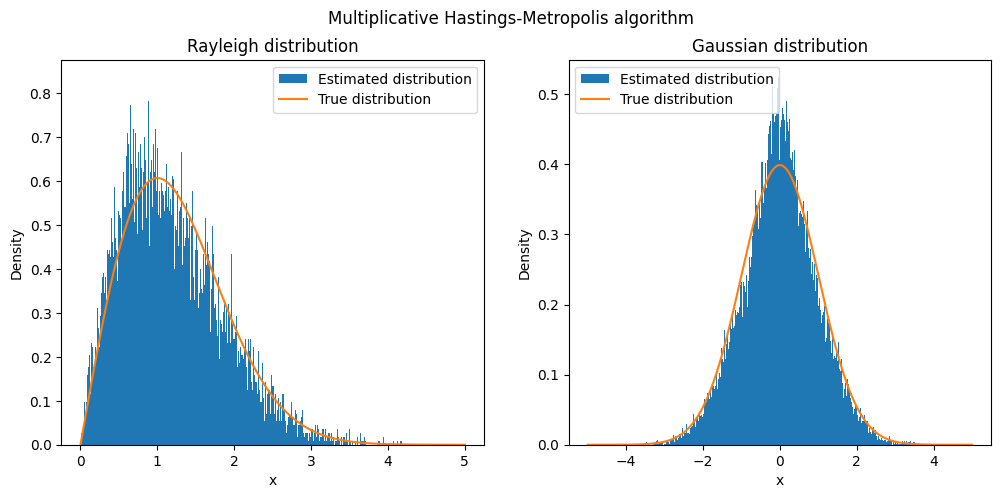

In [51]:
xx_rayleigh = np.linspace(0, 5, 1000)
yy_rayleigh = rayleigh_distribution(xx_rayleigh)
xx_gaussian = np.linspace(-5, 5, 1000)
yy_gaussian = gaussian_density(xx_gaussian)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(rayleigh_states, bins=1000, density=True, label="Estimated distribution")
ax[0].plot(xx_rayleigh, yy_rayleigh, label="True distribution")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Density")
ax[0].legend()
ax[0].set_title("Rayleigh distribution")

ax[1].hist(gaussian_states, bins=1000, density=True, label="Estimated distribution")
ax[1].plot(xx_gaussian, yy_gaussian, label="True distribution")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Density")
ax[1].legend()
ax[1].set_title("Gaussian distribution")

fig.suptitle("Multiplicative Hastings-Metropolis algorithm")
plt.show()